# Introdução
Este notebook faz parte do trabalho de conclusão do curso (TCC) apresentado para obtenção do título de especialista no curso de Ciência de Dados e Big Data na PUC / Minas Gerais.

## Contextualização

O Airbnb é uma plataforma que foi criada em 2007. Seus criadores eram dois amigos que moravam juntos, precisavam de dinheiro, e se aproveitaram de uma oportunidade. Uma grande conferência de design estava acontecendo em São Francisco, onde moravam, e todos os hotéis locais estavam ocupados. Eles decidiram, então, criar a plataforma (que na época se chamava AirBedandBreakfast).</p>

Desde então, a plataforma cresceu significativamente e hoje em dia tem mais de 7 milhões de propriedades listadas, e está disponível em 100.000 cidades em 220 países. 

Essa plataforma cresceu tanto resolvendo um problema importante. O mesmo problema que levou os seus criadores a cria-la originalmente: Unir pessoas com espaço disponível querendo uma renda extra, e pessoas que precisam de um lugar para ficar, e não querem depender de hotéis. Seja por motivo de custo, disponibilidade ou praticidade.

Selecionar um imóvel com bom custo-benefício, entretanto, não é trivial. A plataforma oferece inúmeras opções de customização do anúncio, centenas de possíveis amenidades, descrição do anfitrião, diversas categorias de avaliação, o texto em si das avaliações, dentre outras. 

Esse excesso de atributos faz com que seja difícil, tanto para um anfitrião, quanto para um hóspede de tomar decisão. O anfitrião vai ter como interesse maximizar o lucro do seu imóvel ou espaço disponível, enquanto o hóspede tipicamente terá como interesse principal maximizar o custo-benefício de sua estadia.

## O Problema
Diante desse contexto, este estudo tem como objetivo determinar quais são os principais atributos que contribuem para o preço listado de uma propriedade no Airbnb, tão como criar um modelo de predição para esses preços. Para o estudo, a cidade de Toronto, em Ontario, foi selecionada. Toronto é uma cidade turística que recebe 27.5 milhões de visitantes anualmente, e é o principal destino turístico no Canada.

Para facilitar o entendimento do problema, este estudo inclui a técnica dos 5W’s, que consiste em fazer as seguintes perguntas:

- **Why?** Uma boa modelagem do preço permite a um potencial hóspede maximizar seu custo-benefício, e permite um potencial anfitrião maximizar seu lucro.


- **Who?** Parte dos dados foram coletados pela InsideAirbnb, e são referentes às propriedades listadas na plataforma Airbnb. A outra parte dos dados (geográficos) foram fornecidos pela plataforma Mapquest.

- **What?** São dois objetivos: Predizer o preço listado de um imóvel na plataforma Airbnb a partir destes atributos mais importantes e entender quais são os atributos mais importantes e o impacto destes

- **Where?** Imóveis de toda a cidade de Toronto, localizada na província de Ontário, no Canada.

- **When?** O banco de dados apresenta anúncios cadastrados de anfitriões que estão desde 2008 no Airbnb.


## Fontes de Dados

### Esse script precisa das seguintes fontes de dados:
>listings.csv

>reviews.csv (Indiretamente)

- Dados: Imóveis listados em Toronto, Ontario, na plataforma Airbnb em 08 de Fevereiro de 2021. Indexados pelo ID do anúncio.
- Fonte: Através da execução do script **download_airbnb.ipynb**, que faz download dos dados no site Insideairbnb.com.

>geolocation_data.csv
- Dados: Município dos imóveis listados em **listings.csv**, indexados pelo ID do anúncio.
- Fonte: Através da execução do script **GEO_process_coordinates.ipynb**, que usa o arquivo **listings.csv** como input, e a API do Mapquest para fornecer os dados de geolocalização reversa.

>processed_listing_descriptions_small.csv

>processed_listing_reviews_small.csv

- Dados: Análise de Subjetividade (PLN), com polaridade das descrições dos anúncios no **listings.csv** e **reviews.csv**, respectivamente.
- Fonte(descriptions): Através da execução do script **NLP_process_descriptions.ipynb**, que usa o arquivo **listings.csv** como input.
- Fonte(reviews): Através da execução do script **NLP_process_reviews.ipynb**, que usa o arquivo **reviews.csv** como input.

# 0 - Importing Libraries

In [1]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install statsmodels
#!pip3 install xgboost

In [2]:
## Math + Charts + Stats
import math
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

# Geo Localization
import folium
from folium.plugins import FastMarkerCluster, HeatMap

# Images
from IPython import display

# Models + Metrics
from sklearn import preprocessing, linear_model, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

# Performance
from datetime import datetime
import time

warnings.filterwarnings('ignore')
%matplotlib inline

# 1 - Reading and Importing Data

## Definindo o PATH dos arquivos

In [3]:
# Files from external sources
file_toronto_listings = "../2-data/input/Toronto_2021-02-08/listings.csv"

# Files preprocessed by auxiliary scripts
file_processed_descriptions = '../2-data/generated/processed_listing_descriptions_small.csv' #NLP
file_processed_reviews      = '../2-data/generated/processed_listing_reviews_small.csv'      #NLP
file_geolocation_data       = "../2-data/generated/geolocation_data.csv"                     #Geo-localização

# Where figures will be saved (for report)
final_figures = '../3-report/figures/'

In [4]:
# Performance
start_time = time.time()

## Loading Airbnb listings in a pandas dataframe

In [5]:
# File should be generated by download_airbnb.ipynb
df = pd.read_csv(file_toronto_listings, index_col = 'id')

In [6]:
## Basic Configs (.ipynb)
pd.set_option('display.max_rows', 80) 
pd.set_option('display.max_columns', len(df.columns))

In [7]:
print(df.shape)

(15832, 73)


# 2 - Data Cleaning: Converting formats, Missing Values (N/A) and Feature Engineering

## Converting Data Types
### Converting: 'price', 'host_response_rate', "host_acceptance rate" → [Float]

In [9]:
# By Default, 'price' is not in numeric format, but string.
print(df["price"].head())
# Remove  $ from price column (e.g. $ 3,320.00 -> 3,320.00)
df["price"] = df["price"].str.replace('$', '')
# Remove ',' (e.g. $ 3,320.00 -> 3320.00)
df["price"] = df["price"].str.replace(',', '')
# Finally, convert to 'float' format
df["price"] = df["price"].astype(float)

id
1419     $469.00
8077      $96.00
23691     $72.00
27423     $45.00
30931    $128.00
Name: price, dtype: object


In [10]:
# Similarly, host_response_rate and host_acceptance_rate are also not numeric, by default.
df["host_response_rate"]   = df["host_response_rate"].str.replace('%', '').astype(float)
df["host_acceptance_rate"] = df["host_acceptance_rate"].str.replace('%', '').astype(float)

### Converting all boolean columns: "t" / "f" -> 1 / 0

In [11]:
df.replace({'f': 0, 't': 1}, inplace=True)

### Converting all Date Columns

In [12]:
df["host_since"] = pd.to_datetime(df["host_since"])
df["last_scraped"] = pd.to_datetime(df["last_scraped"])
df["first_review"] = pd.to_datetime(df["first_review"])
df["last_review"] = pd.to_datetime(df["last_review"])

## Feature Engineering: New columns from the date columns

In [13]:
# For all date columns we are interested on, we'll calculate the number of days
# in relation to when data was obtained (last_scrapped).
df['host_since_days']   = (df['last_scraped'] - df["host_since"])
df['first_review_days'] = (df['last_scraped'] - df["first_review"])
df['last_review_days']  = (df['last_scraped'] - df["last_review"])

# Converting to days precision (timedelta64[ns] -> timedelta64[D])
df['host_since_days']   = df['host_since_days'].astype('timedelta64[D]') 
df['first_review_days'] = df['first_review_days'].astype('timedelta64[D]') 
df['last_review_days']  = df['last_review_days'].astype('timedelta64[D]') 

In [14]:
df[['host_since_days','last_scraped','host_since']].head()

,host_since_days,last_scraped,host_since
id,,,
1419,4568.0,2021-02-09,2008-08-08
8077,4250.0,2021-02-09,2009-06-22
23691,3986.0,2021-02-11,2010-03-15
27423,3935.0,2021-02-10,2010-05-04
30931,4250.0,2021-02-09,2009-06-22


## Removing unused columns (Text, metadata, url)

In [15]:
# Os IDs e datas de quando os dados foram obtidos não contribuem para o modelo. O único ID mantido vai ser o do listing, que é único para todas as linhas.
# As colunas de texto serão utilizadas, mas no módulo de processamento de NLP, que é separado deste para otimizar a performance.
# A coluna de geo-locação (neighbourhood) também vai ser processada de outra forma, através da latitude e longitude, posteriormente.
# As URLs também não contribuem para o modelo.

text_cols = ['name', 'description', 'neighborhood_overview', 'host_name', 'host_location', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood']
metadata_cols = ['scrape_id', 'last_scraped', 'calendar_last_scraped']
url_cols = ['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
drop_columns = text_cols + metadata_cols + url_cols

df.drop(drop_columns, axis=1, inplace=True)

# Performance
print ("Remoção a total of " + str(len(drop_columns)) + " columns.")

Remoção a total of 17 columns.


## Remoção de Colunas: disponibilidade = 0 (em 365 dias) + 0 totais - i.e. Propriedades usadas para especulação / fora do mercado e pausadas

In [16]:
# Propriedades listadas com 0 dias disponíveis no próximo ano, e 0 reviews estão, muito provavelmente, fora de mercado, pausadas ou são usadas exclusivamente para epeculação.
# Por isso, vamos remover essas Propriedades
print("Um total de " + str(df.loc[(df['availability_365'] == 0) & (df['number_of_reviews'] == 0)].shape[0]) + " propriedades foram removidas.")
df.drop(df.loc[(df['availability_365'] == 0) & (df['number_of_reviews'] == 0)].index, inplace=True)

Um total de 1301 propriedades foram removidas.


## Tratamento de Colunas relacionadas ao anfitrição ('..._host_...')

### Valores N/A (host_since_days): Remoção das linhas

In [17]:
## 15 linhas tem diversas colunas em branco, todas relacionadas ao host.
## Como são relativamente poucas linhas, e tem muitas propriedades faltantes que não contribuiram com a análise, estas serão removidas.

print(df.loc[(df['host_since_days'].isna() == 1) & (df['host_since'].isna() == 1) & (df['host_response_time'].isna() == 1) & (df['host_response_rate'].isna() == 1) & (df['host_response_time'].isna() == 1) ].shape)
df.drop(df.loc[(df['host_since_days'].isna() == 1) & (df['host_response_time'].isna() == 1) & (df['host_response_rate'].isna() == 1)].index, inplace=True)

(15, 59)


### Valores N/A (host_response_time): Categorização (N/A = Falta de resposta)

In [18]:
# Quantidade de valores nulos (em branco)
# 5502 valores nulos. Como são muitos valores, é inviável remover tudo. Também não temos como utilizar a média ou mediana, visto que isso iria mascarar os dados.
# Vamos passar a tratar esses valores como categórico, e, nesse caso valores nulos significam valores sem respostas.

print(df['host_response_time'].isna().sum()) #5502 valores em branco
df['host_response_time'].fillna('no response yet', inplace=True)
df['host_response_time'].value_counts()

5487


no response yet       5487
within an hour        5453
within a few hours    1671
within a day          1230
a few days or more     675
Name: host_response_time, dtype: int64

### Remoção de colunas identicas: calculated_host_listings_count, host_listings_count e host_total_listings_count

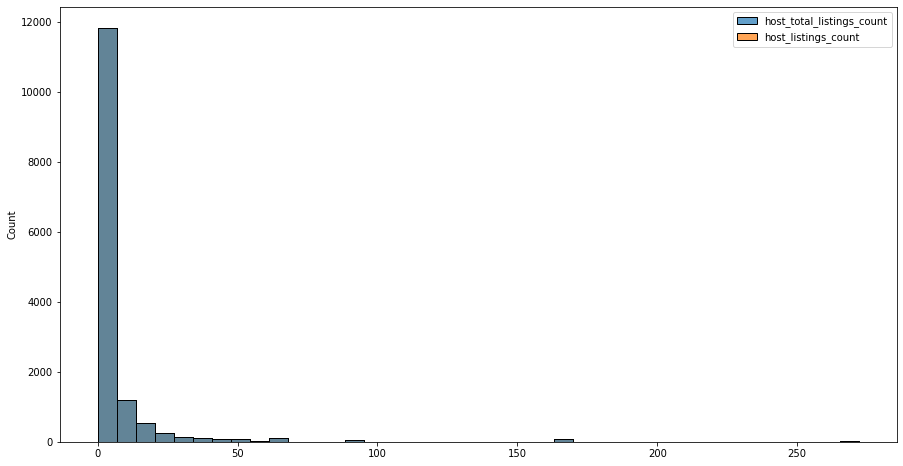

In [19]:
# host_listings_count é completamente igual ao host_total_listings_count. Por isso, apenas precisamos de uma delas.
# Essas colunas também consideram propriedades FORA de Toronto (por exemplo, em outros países)
# Por isso, vamos remover ambas e utilizar apenas o "calculated_host_listings_count", que são exclusivamente propriedades em Toronto.

plt.figure(figsize=(15,8))
sns.histplot([df["host_total_listings_count"],df["host_listings_count"]], multiple='dodge', alpha=0.7, bins=40)

df.drop("host_total_listings_count", axis=1, inplace=True)
df.drop("host_listings_count", axis=1, inplace=True)


### Remoção de colunas calculadas ("calculated_host_listings_count_entire_homes", "..._private_rooms", "..._sharedrooms")

In [20]:
# O website possui colunas que são calculadas automaticamente, juntando os host_listings_count com property_types. 
# Vamos processar diretamente o property_type, então não precisamos dessas colunas.

drop_columns = ["calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"]
df.drop(drop_columns, axis=1, inplace=True)

### Remoção de colunas com mais de 90% dos dados em uma só uma categoria ('host_has_profile_pic', 'has_availability')

1.0    14475
0.0       41
Name: host_has_profile_pic, dtype: int64
1    14292
0      224
Name: has_availability, dtype: int64


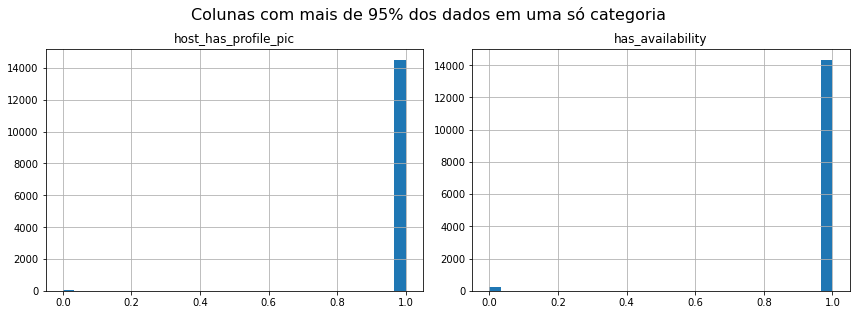

In [21]:
# As colunas a seguir são todas muito similares. Por isso, vamos selecionar apenas duas (maximum_nights, minimum_nights) e 
# remover as outras, para evitar colinearidade dos lados durante a criação do modelo.
print(df["host_has_profile_pic"].value_counts()) #14475 valores são 1.0 (>90%)
print(df["has_availability"].value_counts()) #14292 valores são 1.0 (>90%)

one_sided_columns = ['host_has_profile_pic','has_availability']
sub_title = 'Colunas com mais de 95% dos dados em uma só categoria'

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(one_sided_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(bins=30,ax=ax)
    
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

df.drop(['has_availability', 'host_has_profile_pic'], axis=1, inplace=True)
#fig.savefig(final_figures+"one_category.jpeg",format='jpeg', dpi=300)

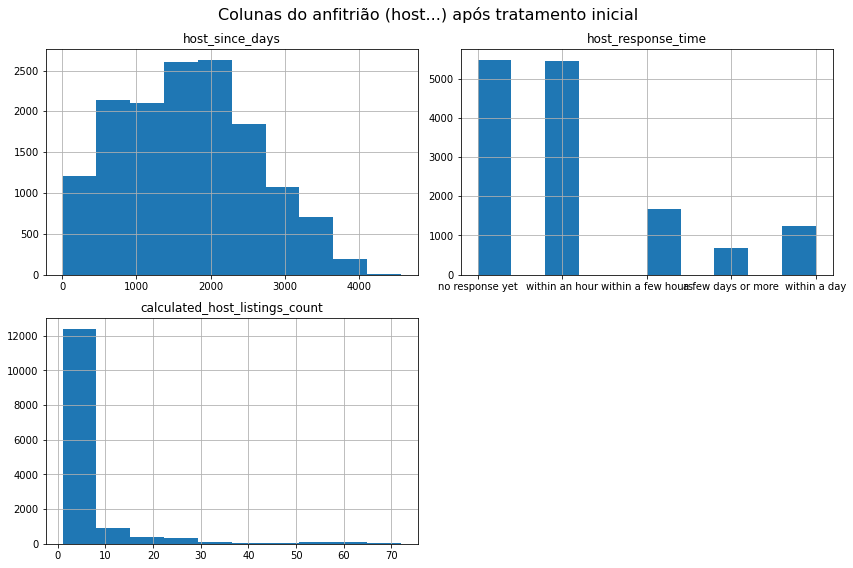

In [22]:
host_columns = ['host_since_days','host_response_time','calculated_host_listings_count']
sub_title = 'Colunas do anfitrião (host...) após tratamento inicial'

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(host_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(ax=ax)
    ax.set_title(var_name)    
fig.tight_layout()

#plt.title(title, fontsize=title_fsize)
#plt.xlabel(xlabel, fontsize=label_fsize)
#plt.ylabel(ylabel, fontsize=label_fsize)
#plt.xticks(fontsize=tick_fsize)
#plt.yticks(fontsize=tick_fsize)

plt.show()

#fig.savefig("host_columns.jpeg",format='jpeg', dpi=300)

### Engenharia de Atributos: Separação de host_response_rate e host_acceptance_rate em bins

In [23]:
# Temos 5487 linhas em branco. Similar ao host_response_time, vamos tratar como variável categórica.
# Entretanto, como esse atributo tem formato numérico, vamos precisar também separar em bins.
print(df['host_response_rate'].isna().sum())
print(df['host_acceptance_rate'].isna().sum())

5487
3978


In [24]:
# Separando em bins
df['host_response_rate'] = pd.cut(df['host_response_rate'], 
                               bins=[0, 60, 91, 99, 100], 
                               labels=['0-60%', '60-91%', '90-99%', '100%'], 
                               include_lowest=True)

# Convertendo em string, substituindo os N/As por categóricos
df['host_response_rate'] = df['host_response_rate'].astype('str')
df['host_response_rate'].fillna('no response yet', inplace=True)

# Category counts
df['host_response_rate'].value_counts()


100%               6269
no response yet    5487
60-91%             1103
0-60%               897
90-99%              760
Name: host_response_rate, dtype: int64

In [25]:
# Separando em bins
df['host_acceptance_rate'] = pd.cut(df['host_acceptance_rate'], 
                               bins=[0, 74, 92, 99, 100], 
                               labels=['0-74%', '74-92%', '92-99%', '100%'], 
                               include_lowest=True)

# Convertendo em string, substituindo os N/As por categóricos
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype('str')
df['host_acceptance_rate'].fillna('no response yet', inplace=True)

# Category counts
df['host_acceptance_rate'].value_counts()

no response yet    3978
100%               3262
92-99%             2641
74-92%             2399
0-74%              2236
Name: host_acceptance_rate, dtype: int64

## Remoção de colunas restantes que tem um altíssimo índice de valores faltantes (>70%).

In [26]:
# Colunas que tem um grande número
isNAdf = pd.DataFrame({'column_name':df.isna().sum().index, 'Sum_NA':df.isna().sum().values, "Percent_NA":(df.isna().sum().values/df.shape[0]*100)})

# Filtrando só pelas colunas com >70% dados faltantes e removendo estas
drop_columns = isNAdf[isNAdf.Percent_NA > 70]["column_name"]
df.drop(drop_columns, axis=1, inplace=True)

print("Dropping a total of " + str(len(drop_columns)) + " columns.")
print(isNAdf[isNAdf.Percent_NA > 70])

Dropping a total of 4 columns.
                     column_name  Sum_NA  Percent_NA
8   neighbourhood_group_cleansed   14516  100.000000
14                     bathrooms   14516  100.000000
28              calendar_updated   14516  100.000000
45                       license   10774   74.221549


## Colunas relacionadas aos Imóveis  (Casa, apartamento, hotel): availability, property_type e room_type, bathrooms, beds, bedrooms e amenities)

## Remoção de colunas redundantes: Minimum / maximum available nights

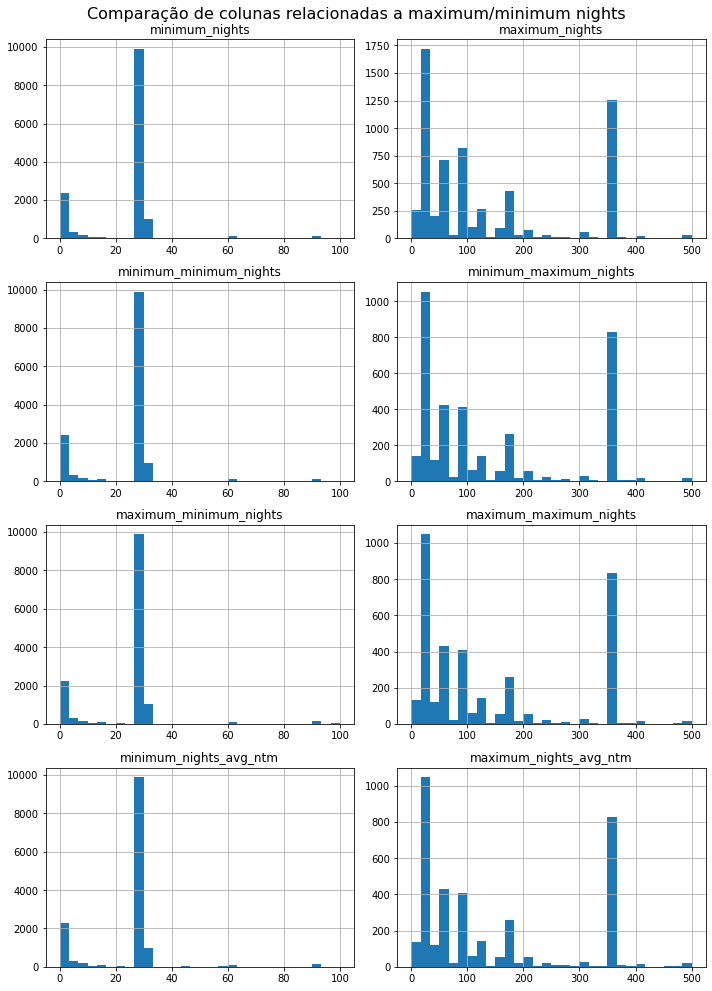

In [27]:
# As colunas a seguir são todas muito similares. Por isso, vamos selecionar apenas duas (maximum_nights, minimum_nights) e 
# remover as outras, para evitar colinearidade dos lados durante a criação do modelo.

nights_columns=['minimum_nights','maximum_nights','minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
sub_title = 'Comparação de colunas relacionadas a maximum/minimum nights'

fig = plt.figure(figsize=(10,14))
for i, var_name in enumerate(nights_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(4,2,i+1)
    # Para plots pares (maximum_...) usamos o range de 500
    if (i%2):
        df[var_name].hist(bins=30,ax=ax, range=(0,500))
    # Para plots ímpares (minimum_...) usamos o range de 100
    else:
        df[var_name].hist(bins=30,ax=ax, range=(0,100))
    
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

#fig.savefig("noites_maximas.jpeg",format='jpeg', dpi=300)

## Remoção de colunas redundantes: availability

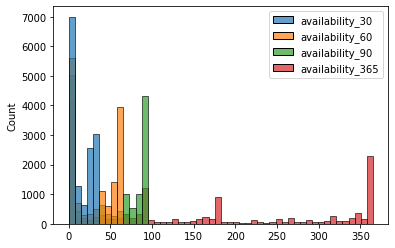

In [28]:
#Por mais que as colunas não sejam úteis pro modelo, algumas métricas serão para a exploração de dados. Portanto, serão obtidas asqui.
count_available_30d = (df['availability_30'] != 0).sum()
count_available_60d = (df['availability_60'] != 0).sum()
count_available_90d = (df['availability_90'] != 0).sum()
count_available_365d = (df['availability_365'] != 0).sum()

#plt.figure(figsize=(15,8))

figure=sns.histplot([df["availability_30"],df["availability_60"],df["availability_90"],df["availability_365"]], multiple='dodge', alpha=0.7, bins=50)

#As colunas são bem parecidas, com a availability_365 sendo a mais completa. Por isso, vamos manter apenas ela.
df.drop(['availability_30', 'availability_60', 'availability_90'], axis=1, inplace=True)

#figure.figure.savefig("availability.jpeg",format='jpeg', dpi=300)

### Engenharia de Atributos: Re-categorização de property_type

In [30]:
# Interessante que temos 2 RVs e 3 boats
print(df['property_type'].nunique())
df['property_type'].value_counts()

61


Entire condominium                    3477
Entire apartment                      2963
Private room in house                 2362
Entire house                          1487
Private room in apartment              896
Entire guest suite                     613
Private room in condominium            506
Private room in townhouse              376
Private room in bungalow               335
Entire townhouse                       272
Entire loft                            241
Entire bungalow                        179
Private room in guest suite            119
Room in boutique hotel                  83
Shared room in house                    80
Private room in villa                   64
Private room in guesthouse              48
Entire guesthouse                       45
Shared room in apartment                45
Room in hotel                           39
Shared room in condominium              35
Private room in bed and breakfast       30
Shared room in townhouse                29
Entire serv

In [31]:
df['property_type'].replace({
"Entire condominium"                : "Apartment",
"Entire apartment"                  : "Apartment",
"Private room in house"             : "House",
"Entire House"                      : "House",
"Private room in apartment"         : "Apartment",
"Entire guest suite"                : "Apartment",
"Private room in condominium"       : "Apartment",
"Private room in townhouse"         : "House",
"Private room in bungalow"          : "House",
"Entire townhouse"                  : "House",
"Entire loft"                       : "Apartment",
"Entire bungalow"                   : "House",
"Private room in guest suite"       : "Apartment",
"Shared room in house"              : "House",
"Room in boutique hotel"            : "Hotel",
"Private room in villa"             : "House",
"Shared room in apartment"          : "Apartment",
"Private room in guesthouse"        : "House",
"Entire guesthouse"                 : "House",
"Room in hotel"                     : "Hotel",
"Shared room in condominium"        : "Apartment",
"Entire serviced apartment"         : "Apartment",
"Shared room in townhouse"          : "House",
"Private room in loft"              : "Apartment",
"Room in hostel"                    : "Hotel",
"Entire villa"                      : "House",
"Private room in serviced apartment": "Apartment",
"Room in aparthotel"                : "Hotel",
"Shared room in tiny house"         : "House",
"Shared room in bungalow"           : "House",
"Private room in tiny house"        : "House",
"Tiny house"                        : "House",
"Private room in hostel"            : "Hotel",
"Private room in cottage"           : "House",
"Entire cottage"                    : "House",
"Entire house"                      : "House",
}, inplace = True)
df.loc[~df.property_type.isin(['House', 'Apartment', "Hotel"]), 'property_type'] = 'Other'

In [32]:
# Seeing new count and adding a % total
propertyTypesSeries = df['property_type'].value_counts()
propertyTypesdf = pd.DataFrame({'Tipo de Propriedade':propertyTypesSeries.index, 'Quantidade':propertyTypesSeries.values, "Fração do Total":(propertyTypesSeries.values/df.shape[0]*100)})
propertyTypesdf

,Tipo de Propriedade,Quantidade,Fração do Total
0,Apartment,8950,61.656104
1,House,5325,36.683659
2,Hotel,161,1.109121
3,Other,80,0.551116


### Analise room_types

In [33]:
# Seeing new count and adding a % total
roomTypesSeries = df.room_type.value_counts()
roomTypesdf = pd.DataFrame({'Tipo de Acomodação':roomTypesSeries.index, 'Quantidade':roomTypesSeries.values, "Fração do Total":(roomTypesSeries.values/df.shape[0]*100)})
roomTypesdf

,Tipo de Acomodação,Quantidade,Fração do Total
0,Entire home/apt,9349,64.404795
1,Private room,4912,33.838523
2,Shared room,210,1.446680
3,Hotel room,45,0.310003


### Valores N/A Bathrooms (Remoção) e subsequente categorização

In [34]:
# Usando a própria definição do Air BNB, "Half bathroom" (0.5) significa um banheiro só com privada e pia, sem chuveiro (Toilet and Sink, no tub or shower)
# https://community.withairbnb.com/t5/Help/Meaning-of-Indicating-bathroom-as-1-or-0-5/td-p/105155

print(df['bathrooms_text'].value_counts())

df['bathrooms_text'].replace({
"Shared half-bath"                  : 0.5,
"Private half-bath"                 : 0.5,
"half-bath"                         : 0.5,
"Half-bath"                         : 0.5,
}, inplace = True)

1 bath               7282
1 shared bath        2388
2 baths              1573
1 private bath       1219
1.5 baths             623
1.5 shared baths      356
2 shared baths        336
2.5 baths             225
3 baths               170
3.5 baths              64
3 shared baths         56
2.5 shared baths       44
4 baths                30
4.5 baths              26
0 shared baths         21
0 baths                17
Shared half-bath       14
3.5 shared baths       13
5 baths                 9
Half-bath               8
Private half-bath       6
6 baths                 5
5.5 baths               4
4 shared baths          4
6.5 baths               4
4.5 shared baths        1
12 baths                1
5 shared baths          1
7.5 baths               1
Name: bathrooms_text, dtype: int64


In [35]:
# Extração dos números dos banheiros. Aqui, nós não vamos categorizar os banheiros como sendo shared-bath ou private-bath, pois isso segmentaria demais os dados.
# Além disso, essa categoria de shared- ou private- já está sendo considerada no room_type, então considerar aqui poderia gerar problemas de colinearidade.
# "0.5 bathrooms", nesse contexto, significa um half-bathroom. "1.5 bathrooms" significa um full-bathroom e um half-bathroom.

df['bathrooms_text'] = df['bathrooms_text'].str.extract('(\d+.\d?)')
df['bathrooms_text'].astype('float64')

df["bathrooms_text"].isna().sum() #43
df.dropna(subset=['bathrooms_text'], inplace=True)
df['bathrooms_text']=df['bathrooms_text'].astype('float64')


### Valores N/A ('Beds' & 'bedrooms'): Preenchimento pela mediana

In [36]:
print(df['beds'].isna().sum()) #168 dados
print(df['bedrooms'].isna().sum()) #1100 dados

df['beds'].fillna(df['beds'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)

168
1100


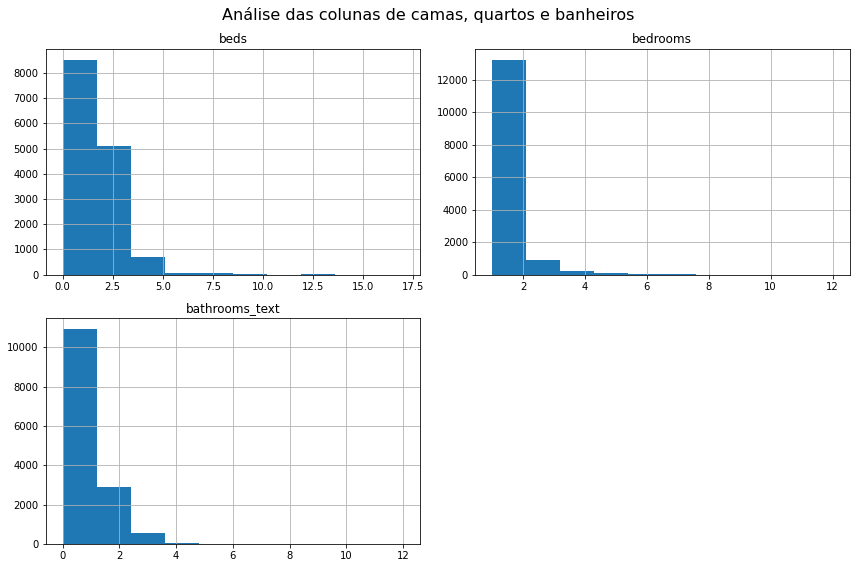

In [37]:
# Checando a distribuição das últimas colunas
processed_columns = ['beds', 'bedrooms', 'bathrooms_text']
sub_title = "Análise das colunas de camas, quartos e banheiros"

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(processed_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"Imoveis.jpeg",format='jpeg', dpi=300)

### Engenharia de Atributos: Categorização de Amenidades (Amenities)

In [38]:
# Para lidar com as Amenidades, vamos precisar processar e separar as listas, contabilizar as mais comuns por propriedade
# e criar diversas colunas para cada uma dessas.

# Criando uma lista com todas as amenidades
amenities_list = " ".join(list(df.amenities))
amenities_list = amenities_list.replace('{', '').replace('}', ',')
amenities_list = amenities_list.replace('[', '').replace(']', ',')
amenities_list = amenities_list.replace('"', '')

# A forma que os dados são importados tem alguns erros / artefatos
# Esses vão ser tratados aqui: \u2019s significa ' (Exemplo: "Children\u2019s dinnerware", que deveria ser "Children's dinnerware"). 
# Similarmente, \u2019n representa /
# Finalmente, \ representa inches (12 \ TV → 12 inches TV)
# Todas as conversões / replacements serão feitos a seguir
amenities_list = amenities_list.replace('\\u2019s', '`')
amenities_list = amenities_list.replace('\\u2019n', '/')
amenities_list = amenities_list.replace('\\', ' inches')
#print(amenities_list)

my_list = amenities_list.split(", ")
print(len(my_list)) #378.502 amenities on total

#Counter(my_list).most_common()[0:43] #Pelo menos 2200 casos/exemplos do item

378502


In [39]:
# Criação das colunas binárias, uma para cada amenidade. Nota que, intencionalmente as colunas são nomeadas com o prefixo am_, para filtrar facilmente  depois
# Ex: "am_TV", "am_microwave"

for x in range(43):
    amenityName = Counter(my_list).most_common()[x][0]
    df.loc[df['amenities'].str.contains(amenityName), 'am_' + amenityName] = 1
    #NOTE: Comentado para economizar tempo / espaço
    #print ("Column "+ amenityName + " Added. This column has " + str(Counter(my_list).most_common()[x][1]) + " occurrencies (" + str(round((Counter(my_list).most_common()[x][1]/401040)*100)) + "% of total)")
    # Os casos com N/A aqui, representam propriedades sem essa amenidade.
    df['am_' + amenityName].fillna(0, inplace = True) 

# Podemos remover a coluna principal, agora que criamos uma para cada caso.    
df.drop(["amenities"], axis=1, inplace=True)

## Propriedades relacionadas a Avaliações (first_ e last_reviews, review_scores, review_number)

### Preenchimento de N/As: Categorização em bins de first_review_days e last_review_days

<AxesSubplot:ylabel='Count'>

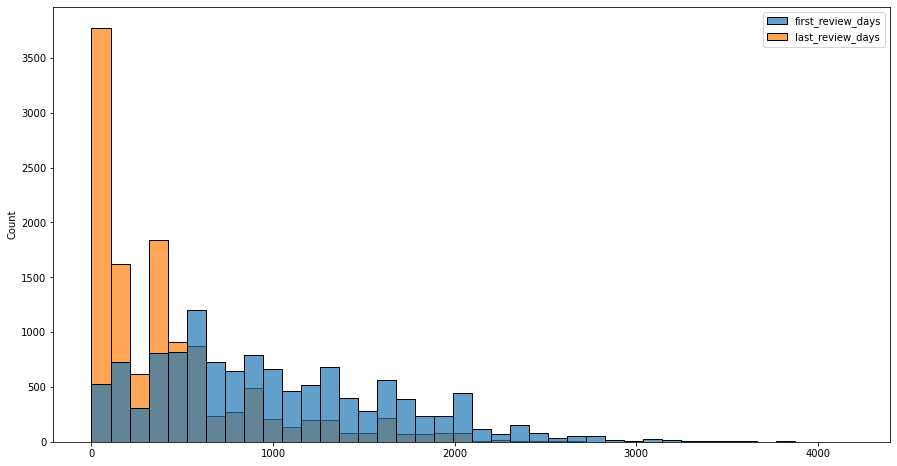

In [40]:
plt.figure(figsize=(15,8))
sns.histplot([df["first_review_days"],df["last_review_days"]], multiple='dodge', alpha=0.7, bins=40)

In [41]:
print(df['first_review_days'].isna().sum())
print(df['last_review_days'].isna().sum())

2361
2361


In [42]:
# Separando em bins com o mesmo procedimento de host_response_rate
df['first_review_days'] = pd.cut(df['first_review_days'], 
                        bins=[0, 365/2, 365, 365*2, 365*4, max(df['first_review_days'])],
                        labels=['0-6 months',
                                '6-12 months',
                                '1-2 years',
                                '2-4 years',
                                '4+ years'],
                               include_lowest=True)

df['first_review_days'] = df['first_review_days'].astype('str')
df['first_review_days'].fillna('no review yet', inplace=True)
df['first_review_days'].value_counts()

2-4 years        4186
1-2 years        3173
4+ years         2816
no review yet    2361
0-6 months       1080
6-12 months       857
Name: first_review_days, dtype: int64

In [43]:
# Separando em bins com o mesmo procedimento de host_response_rate
df['last_review_days'] = pd.cut(df['last_review_days'], 
                        bins=[0, 365/2, 365, 365*2, 365*4, max(df['last_review_days'])],
                        labels=['0-6 months',
                                '6-12 months',
                                '1-2 years',
                                '2-4 years',
                                '4+ years'],
                               include_lowest=True)

df['last_review_days'] = df['last_review_days'].astype('str')
df['last_review_days'].fillna('no review yet', inplace=True)
df['last_review_days'].value_counts()

0-6 months       5139
1-2 years        2672
no review yet    2361
6-12 months      2052
2-4 years        1599
4+ years          650
Name: last_review_days, dtype: int64

### Reviews: Scores

2550


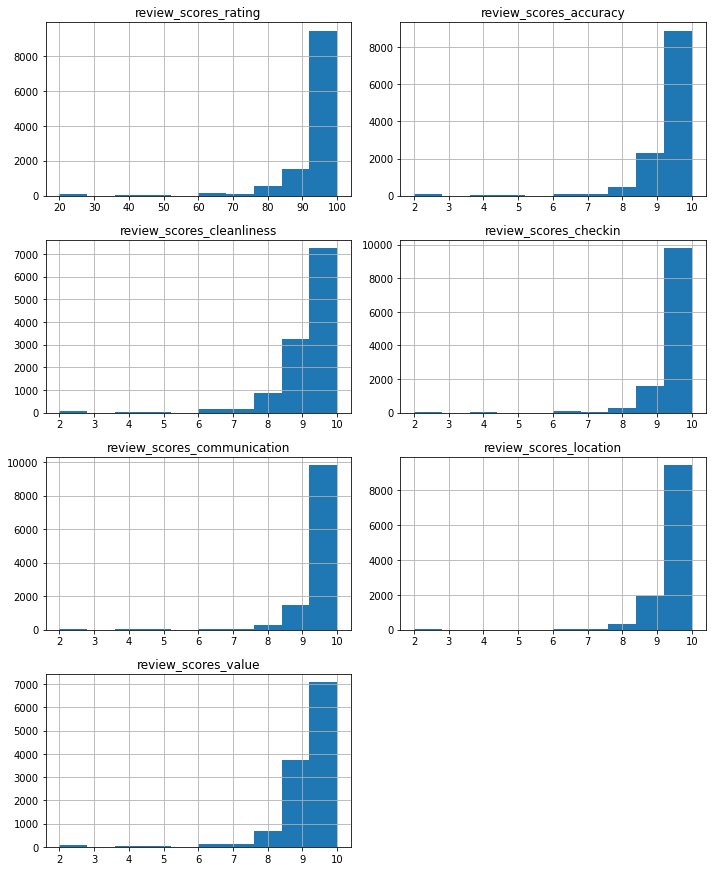

In [44]:
print(df['review_scores_rating'].isna().sum())

# Checking the distributions of the review ratings columns
review_columns = list(df.columns[df.columns.str.startswith("review_scores") == True])
#review_columns = ['review_scores_rating', 'review_scores_accuracy']
fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(review_columns):
    #ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(6,2, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"dist_primeiras_review_scores.jpeg",format='jpeg', dpi=300)

In [45]:
#Vamos remover review_scores_rating, pois é simplesmente uma soma das outras colunas. Nós vamos usar as outras colunas diretamente
df = df.drop("review_scores_rating", axis=1)

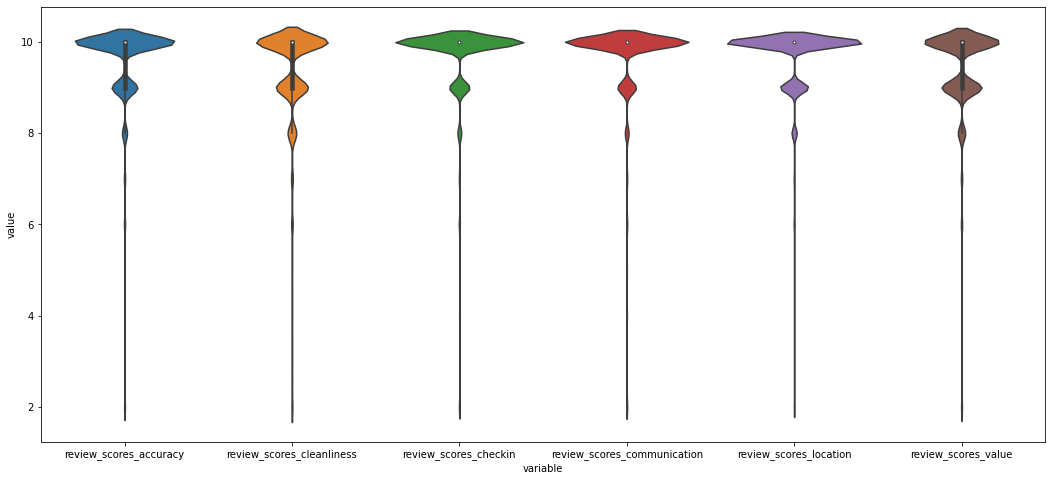

In [46]:

# Possível ver que todos os reviews são fortemente concentrados em valores superiores (8,9,10)

# Para fazer um violin plot, vamos derreter as colunas
melted_df = df.copy()
melted_df = pd.melt(melted_df[['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']])
melted_df

plt.figure(figsize=(18,8))
sns.violinplot(x="variable", y="value", data=melted_df)

del melted_df #Otimizar memória utilizada

In [47]:
# Separando em bins com o mesmo procedimento de host_response_rate
for col in ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']:
    df[col] = pd.cut(df[col],
                bins=[0, 5, 8, 9, 10],
                labels=['0-5','5-8', '8-9', '10'],
                include_lowest=True)

    df[col] = df[col].astype('str')
    df[col].fillna('no review yet', inplace=True)

In [48]:
for col in ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']:
    print(df[col].value_counts())
    df[col].value_counts()

10               8872
no review yet    2582
8-9              2271
5-8               632
0-5               116
Name: review_scores_accuracy, dtype: int64
10               7269
8-9              3258
no review yet    2580
5-8              1206
0-5               160
Name: review_scores_cleanliness, dtype: int64
10               9807
no review yet    2582
8-9              1564
5-8               435
0-5                85
Name: review_scores_checkin, dtype: int64
10               9849
no review yet    2581
8-9              1493
5-8               448
0-5               102
Name: review_scores_communication, dtype: int64
10               9458
no review yet    2582
8-9              1925
5-8               457
0-5                51
Name: review_scores_location, dtype: int64
10               7101
8-9              3742
no review yet    2582
5-8               915
0-5               133
Name: review_scores_value, dtype: int64


### Reviews: Remoção de colunas inter-correlacionadas (number_of_reviews_ltm e reviews_per_l30d, mantendo reviews_per_month)

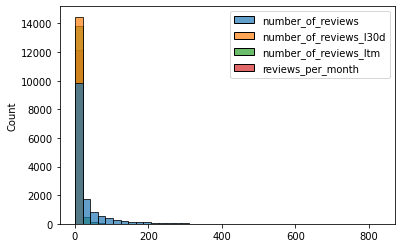

In [49]:
# As colnas "number_of_reviews_ltm" e "reviews_per_l30d" são temporais, recentes e intercorrelacionadas com a reviews_per_month. 
# Por isso, vamos manter só a última, e remover as outras.

ax = sns.histplot(df[['number_of_reviews','number_of_reviews_l30d', 'number_of_reviews_ltm', 'reviews_per_month']], multiple='dodge', alpha=0.7, bins=40)
df.drop(['number_of_reviews_ltm', 'number_of_reviews_l30d'], axis=1, inplace=True)

#ax.figure.savefig(final_figures+"hist_num_reviews.jpeg",format='jpeg', dpi=300)

Tratamento de N/As de reviews_per_month

In [50]:
# Os valores nulos dessa coluna significam listings que ainda não tiveram reviews. Por isso, podemos substui-los por 0.

df['reviews_per_month'].isna().sum()
df['reviews_per_month'].fillna(0, inplace=True)

## Remoção de Outliers: Coluna 'price'

279
92.0
13000.0


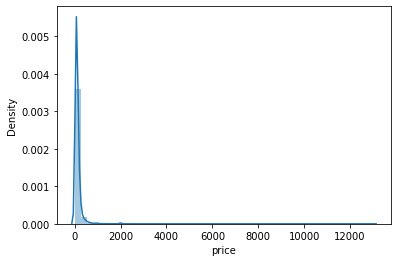

In [51]:
# Os dados de preço são extremamente assimetricos positivamente. 
# 14194 das propriedades tenham uma diária de <= CAD$500, e 317 propriedades (2%) tem um valor >= CAD$500

ax = sns.distplot(df['price'])

print(df.loc[df.price >= 501].count()['price'])
print(df.price.median())
print(df.price.max())

df.drop(df[df.price >= 500].index, inplace=True)
#ax.figure.savefig(final_figures+"hist_price_before.jpeg",format='jpeg', dpi=300)

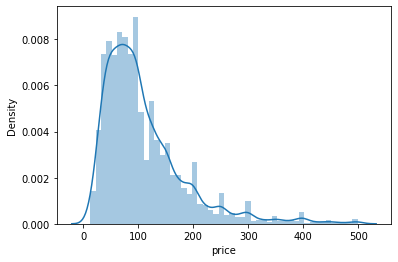

In [52]:
# Agora é possível analisar a distribuição de preços.
# A assimetria continua sendo fortemente positiva, mas agora com muito menos outliers. 
# A assimetria vai ser trabalhada mais a frente.

ax=sns.distplot(df['price'])
#ax.figure.savefig(final_figures+"hist_price_after.jpeg",format='jpeg', dpi=300)

## NLP

### NLP: processed_listing_reviews.csv → review_polarity

In [53]:
processed_reviews = pd.read_csv(file_processed_reviews, index_col = 'listing_id')
processed_reviews.head()

,review_polarity
listing_id,
16442542,0.9975
10428248,0.9972
36349569,0.9972
44162148,0.9966
43147441,0.9965


In [54]:
# Antes de concatenarmos as dataframes, precisamos verificar se a 'processed_reviews' possui alguma coluna que a 'df' não possui.
# Caso positivo, precisamos remover esta coluna, pois os listing_ids não teriam nenhuma outra informação além da polaridade
differentProperties = processed_reviews.index.difference(df.index)
print(len(differentProperties))
# aqui vamos dropar todos os indexes
processed_reviews = processed_reviews[~processed_reviews.index.isin(differentProperties)]

257


In [55]:
#verify integrity para evitar duplicar indexes
df = pd.concat([df, processed_reviews], axis=1, verify_integrity=True)

array([[<AxesSubplot:title={'center':'review_polarity'}>]], dtype=object)

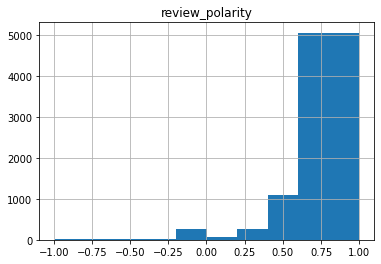

In [56]:
processed_reviews.hist()

In [57]:
#Confirmando que o shape da df original foi mantido, com adição de uma coluna
print(df.shape)
print(processed_reviews.shape)
print(df.shape)

(14156, 79)
(11896, 1)
(14156, 79)


### Engenharia de atributos: Categorização em bins

In [58]:
# Bin into four categories
df['review_polarity'] = pd.cut(df['review_polarity'], 
                               bins=[-1, 0.65, 0.77, 0.85, 1], 
                               labels=['- 65%', '65-77%', '77-85%', '85% +'], 
                               include_lowest=True)

df["review_polarity"].value_counts()

65-77%    3179
85% +     3112
77-85%    3073
- 65%     2532
Name: review_polarity, dtype: int64

### NLP: processed_listing_descriptions.csv → description_polarity

In [59]:
processed_descriptions = pd.read_csv(file_processed_descriptions, index_col = 'id')
processed_descriptions.head()

,description_polarity
id,
2979246,0.9979
26662976,0.9977
39058638,0.9976
3849103,0.9970
21764678,0.9970


In [60]:
processed_descriptions.isna().sum()

description_polarity    0
dtype: int64

In [61]:
# Antes de concatenarmos as dataframes, precisamos verificar se a 'geolocation_df' possui alguma linha que a 'df' não possui.
# Caso positivo, precisamos remover esta linha.
differentProperties = processed_descriptions.index.difference(df.index)
print(len(differentProperties))
processed_descriptions = processed_descriptions[~processed_descriptions.index.isin(differentProperties)]

1580


In [62]:
#verify integrity para evitar duplicar indexes
print(df.shape)
df = pd.concat([df, processed_descriptions], axis=1, verify_integrity=True)

(14156, 79)


In [63]:
#Confirmando que o shape da df original foi mantido, com adição de uma coluna
print(processed_descriptions.shape)
print(df.shape)
#print(df.shape)

(13687, 1)
(14156, 80)


In [64]:
df['description_polarity'].isna().sum() #484 NAs
df['description_polarity'].fillna(df['description_polarity'].median(), inplace=True)

<AxesSubplot:>

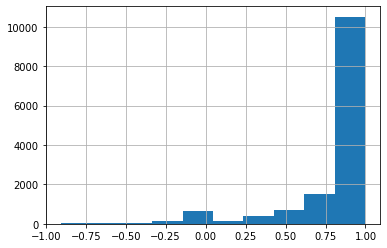

In [65]:
df['description_polarity'].hist()

In [66]:
len(df['neighbourhood_cleansed'])

14156

## Geolocation Data

140


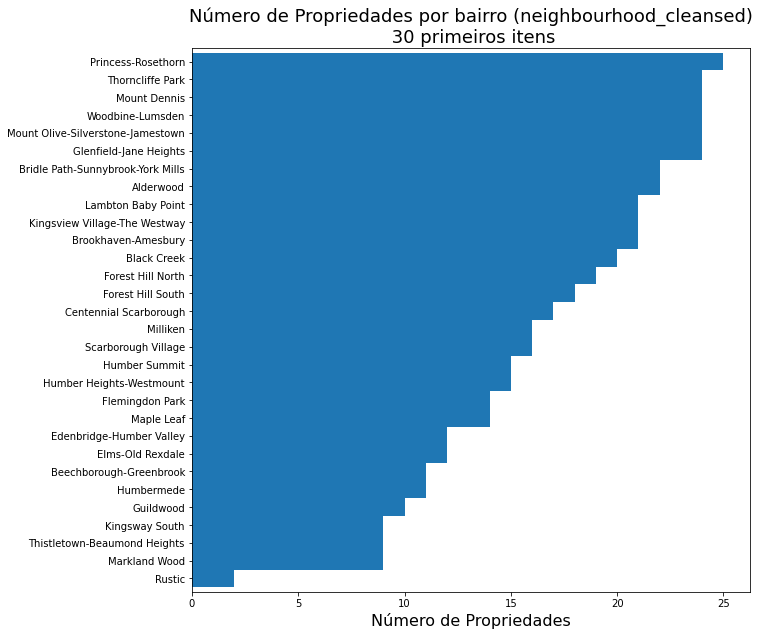

In [67]:
## Não conseguimos usar a coluna neighbourhood_cleansed, porquê tem muitos valores unicos. O item mais frequente tem 25 ocorrências.
## Similarmente, não tem nenhuma coluna que descreva a cidade. Portanto, vamos precisar criar esses dados.

print(df['neighbourhood_cleansed'].nunique())
freq = df['neighbourhood_cleansed'].value_counts().sort_values(ascending=True)
#ax=freq[0:30].plot.barh(figsize=(12,15), width= 1)
ax=freq[0:30].plot.barh(figsize=(10,10), width= 1)
plt.title('Número de Propriedades por bairro (neighbourhood_cleansed)\n 30 primeiros itens', fontsize=18)
plt.xlabel('Número de Propriedades', fontsize = 16)
plt.show()

df.drop('neighbourhood_cleansed', axis=1, inplace=True)

#ax.figure.savefig(final_figures+"neighbourhood_cleansed.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

### Leitura dos dados de Geolocalização

In [68]:
# Os dados de latitude e longitude são processados, separadamente, no notebook Geolocation_process_coordinates.ipynb.
# Depois de processados, a cidade é determinada para cada um dos pares latitude-longitude, que então são lidos por essa célula

geolocation_df = pd.read_csv(file_geolocation_data, index_col = 'listing_id')
geolocation_df = geolocation_df.rename(columns={'City': 'geo_city', 'County': 'geo_county', 'Neighborhood': 'geo_neighborhood'})
# Vamos remover o county, pois todos são listados como Toronto. Remover também geo__neighborhood, porquê é uma coluna em branco.
geolocation_df = geolocation_df.drop(['geo_county', 'geo_neighborhood'], axis=1)

print(geolocation_df.shape)
geolocation_df.head()

(15832, 1)


,geo_city
listing_id,
1419,Toronto
8077,Toronto
23691,York
27423,Toronto
30931,Toronto


In [69]:
# Confirmando que não temos índices duplicados
print(geolocation_df.index.duplicated().sum())

# Antes de concatenarmos as dataframes, precisamos verificar se a 'geolocation_df' possui alguma linha que a 'df' não possui.
# Caso positivo, precisamos remover esta linha.
differentProperties = geolocation_df.index.difference(df.index)
print(len(differentProperties))
geolocation_df = geolocation_df[~geolocation_df.index.isin(differentProperties)]

0
1676


In [70]:
# Verify integrity para evitar duplicar indexes
print(df.shape)
df = pd.concat([df, geolocation_df], axis=1, verify_integrity=True)

(14156, 79)


In [71]:
#Confirmando que o shape da df original foi mantido, com adição de 1 coluna
print(geolocation_df.shape)
print(df.shape)

(14156, 1)
(14156, 80)


0


<AxesSubplot:>

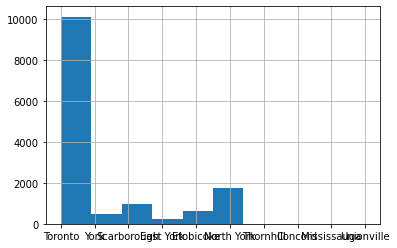

In [72]:
print(df['geo_city'].isna().sum())
df['geo_city'].hist()

In [73]:
# Vamos remover as propriedades em cidades com menos de 2 ocorrências. 
# Elas não auxiliariam no processamento, visualização nem modelagem dos dados.
#print(df['geo_city'].value_counts())

#df['geo_city'].value_counts().to_clipboard()
#Substituição para evitar confusões com o nome de Toronto (Cidade) e Old Toronto (Município)
df['geo_city'] = df['geo_city'].str.replace('Toronto','Old Toronto')
df.drop(df.loc[df['geo_city'] == 'Unionville'].index, inplace=True) # 2
df.drop(df.loc[df['geo_city'] == 'Thornhill'].index, inplace=True) # 2
df.drop(df.loc[df['geo_city'] == 'Mississauga'].index, inplace=True) # 1
df.drop(df.loc[df['geo_city'] == 'Concord'].index, inplace=True) # 1
#df['geo_city'].value_counts()
print(df['geo_city'].value_counts())

Old Toronto    10129
North York      1758
Scarborough      945
Etobicoke        612
York             463
East York        243
Name: geo_city, dtype: int64


In [74]:
# creates 8 clusters using k-means clustering algorithm.
kmeans = KMeans(8)
clusters = kmeans.fit_predict(df[['latitude','longitude']])
df['geo_cluster'] = kmeans.predict(df[['latitude','longitude']])

In [75]:
df['geo_cluster'].value_counts()

6    6160
2    2536
4    1434
0    1319
3     734
7     727
1     620
5     620
Name: geo_cluster, dtype: int64

In [76]:
print(df.shape)
print(73-31) # Colunas originais removidas
print(82-(31)) # Colunas novas criadas
#df.columns

(14150, 81)
42
51


# 3 - Análise Exploratória dos Dados (AED)

In [77]:
#https://www.budgetyourtrip.com/canada/toronto
budgetyourtrip_average_price=224

total_listings = df.shape[0]

num_cities = df['geo_city'].nunique()


total_hosts = df['host_id'].nunique()
median_property_per_host = round(df['calculated_host_listings_count'].median(),1)
max_property_per_host = round(df['calculated_host_listings_count'].max(),1)
skew_property_per_host = round(df['calculated_host_listings_count'].skew(),1)
one_property_host=round(100*len(df[df['calculated_host_listings_count'] == 1])/len(df))


mean_price = round(df['price'].mean(),1)
median_price = round(df['price'].median(),1)


print("Existem um total de {} propriedades listadas em {} cidades dentro de Toronto. Dessas, {} ainda estão imediatamente disponíveis para hospedes no próximo mês. Essas propriedades são listadas por {} anfitriões.".format(total_listings, num_cities, count_available_30d, total_hosts))
print("O número de propriedades por anfitrião é extremamente assimétrico (Assimetria de {}). Na mediana, cada anfitrião lista {} propriedades, mas alguns chegam a listar {} propriedades. Por outro lado, {}% dos anfitriões tem apenas 1 propriedade.".format(skew_property_per_host, median_property_per_host, max_property_per_host, one_property_host))
print("Em média, um hóspede pagaria uma diária de CAD$ {} para conseguir uma propriedade em Toronto. Isso ainda é mais barato que um hotel que de acordo com budgetyourtrip.com custa em média CAD$ {} por dia. ".format(mean_price, budgetyourtrip_average_price))

Existem um total de 14150 propriedades listadas em 6 cidades dentro de Toronto. Dessas, 8497 ainda estão imediatamente disponíveis para hospedes no próximo mês. Essas propriedades são listadas por 8853 anfitriões.
O número de propriedades por anfitrião é extremamente assimétrico (Assimetria de 4.0). Na mediana, cada anfitrião lista 2.0 propriedades, mas alguns chegam a listar 72 propriedades. Por outro lado, 48% dos anfitriões tem apenas 1 propriedade.
Em média, um hóspede pagaria uma diária de CAD$ 110.2 para conseguir uma propriedade em Toronto. Isso ainda é mais barato que um hotel que de acordo com budgetyourtrip.com custa em média CAD$ 224 por dia. 


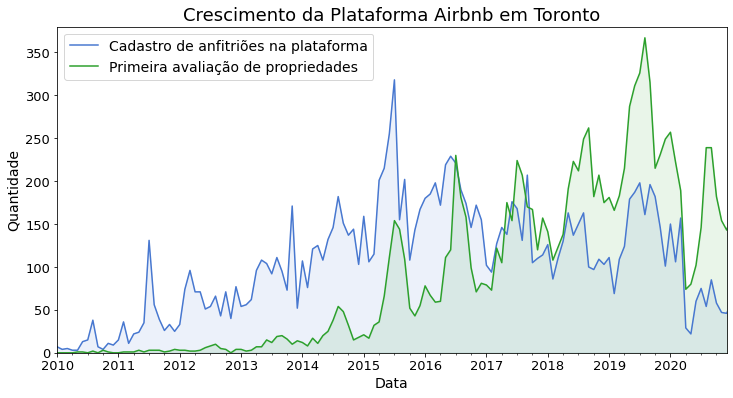

In [78]:
# Nota para queda signfiicativa em 2020 (Pandemia) 

# Configurações do Gráfico - Texto
title='Crescimento da Plataforma Airbnb em Toronto'
xlabel='Data'
ylabel='Quantidade'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

# Gráfico
plt.figure(figsize=(12,6))
ax = df.set_index('host_since').resample('M').size().plot(label='Cadastro de anfitriões na plataforma', color=sns.color_palette("muted"))
ax = df.set_index('first_review').resample('M').size().plot(label='Primeira avaliação de propriedades', color=sns.color_palette("tab10")[2])

# Vamos limitar de 2010 a 2020, pulando o começo de 2021 para melhorar a visualização
plt.xlim('2010-01-01', '2020-12-30') 
plt.ylim(0, 380) 

# Selecionando as linhas para fazer sombreamento
l1 = ax.lines[0]
l2 = ax.lines[1]

# Gerando o sombreamento
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color=sns.color_palette("muted"), alpha=0.1)
ax.fill_between(x2,y2, color=sns.color_palette("tab10")[2], alpha=0.1)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

plt.show()

#ax.figure.savefig(final_figures+"cresc_airbnb.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

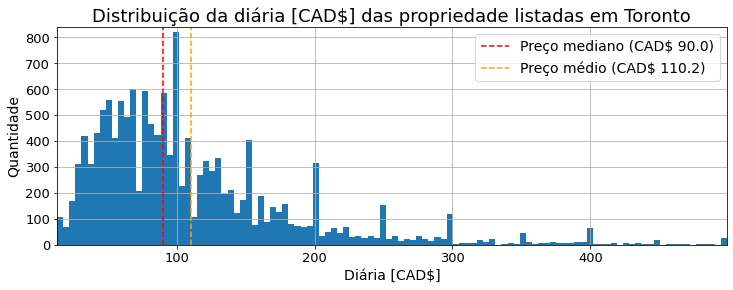

In [79]:
## Configurações do Gráfico - Texto
title='Distribuição da diária [CAD$] das propriedade listadas em Toronto'
xlabel='Diária [CAD$]'
ylabel='Quantidade'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

plt.figure(figsize=(12,4))
df['price'].hist(bins=110)
plt.margins(x=0, y=0.02)

plt.axvline(median_price, color='red'   , linestyle='--', label='Preço mediano (CAD$ '+str(median_price)+')')
plt.axvline(mean_price  , color='orange', linestyle='--', label='Preço médio (CAD$ '+str(mean_price)+')')


plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

#plt.savefig(final_figures+"diaria.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

plt.show()

## Análise Do Anfitrião

### Quantidade de Anúncios / Propriedades

In [80]:
## Host com mais listings
df['host_id'].value_counts().head(10)

#setting figure size for future visualizations
#sns.set(rc={'figure.figsize':(10,8)})
#sns.set_style('white')
top_host_df=pd.DataFrame()
top_host_df=pd.DataFrame(df['host_id'].value_counts().head(10))
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'host_id', 'host_id':'listing_count'}, inplace=True)
top_host_df = top_host_df.sort_values(["listing_count"]).reset_index(drop=True)
print(top_host_df)

plot_order = top_host_df.groupby('host_id')['listing_count'].sum().sort_values(ascending=False).index.values
#plot_order

     host_id  listing_count
0  301014754             30
1   26743967             30
2  327456656             36
3  135718015             37
4     846505             47
5     785826             50
6  293274089             54
7  152088065             58
8    1919294             64
9   10202618             69


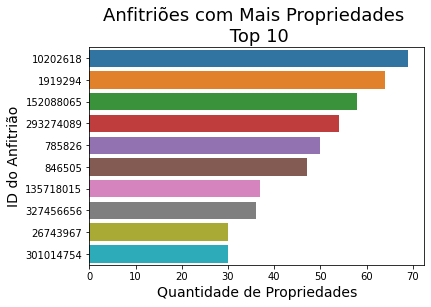

In [81]:
# Configurações do Gráfico - Texto
title = 'Anfitriões com Mais Propriedades \n Top 10'
xlabel = 'Quantidade de Propriedades'
ylabel = 'ID do Anfitrião'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=10

sns.barplot(y="host_id", x="listing_count", data=top_host_df, orient='h', order = plot_order);

plt.title(title, fontsize=title_fsize);
plt.xlabel(xlabel, fontsize=label_fsize);
plt.ylabel(ylabel, fontsize=label_fsize);
plt.xticks(fontsize=tick_fsize);
plt.yticks(fontsize=tick_fsize);

#plt.savefig(final_figures+"most_prop_host.jpeg",format='jpeg', dpi=300, bbox_inches='tight')


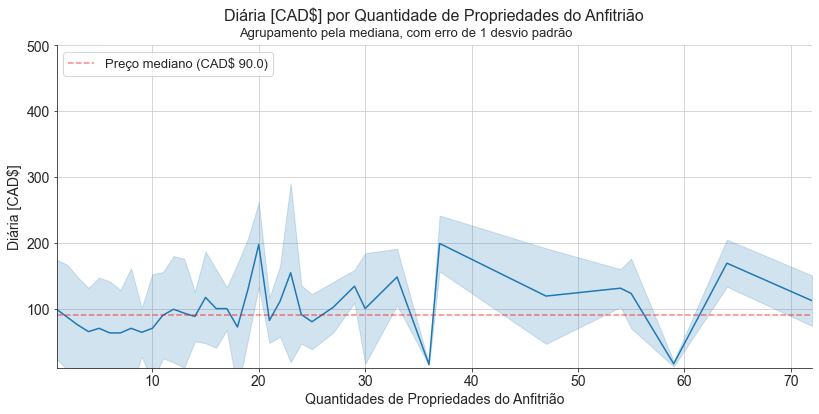

In [82]:
# Configurações do Gráfico - Texto
title='Diária [CAD$] por Quantidade de Propriedades do Anfitrião'
subtitle='Agrupamento pela mediana, com erro de 1 desvio padrão'
xlabel='Quantidades de Propriedades do Anfitrião'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=13
label_fsize=14
tick_fsize=14
legend_fsize=13


sns.set_style("ticks")
g = sns.relplot(x='calculated_host_listings_count', y='price', data=df, estimator='median', kind="line", ci="sd", ax=ax).set(xlim=(1,72), ylim=(10,500) )
plt.axhline(median_price, color='red', linestyle='--', label='Preço mediano (CAD$ '+str(median_price)+')', alpha = 0.5)
g.fig.set_size_inches(12,5)

plt.suptitle(subtitle, fontsize=subtitle_fsize, y=1.02)
plt.title(title, fontsize=title_fsize, y=1.06)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(loc='upper left', fontsize=legend_fsize)

#plt.savefig(final_figures+"price_per_prop.jpeg",format='jpeg', dpi=300, bbox_inches='tight')


plt.grid()


### Anfitrião é um super host?

0.0    0.71
1.0    0.29
Name: host_is_superhost, dtype: float64


Text(0.5, 0, '')

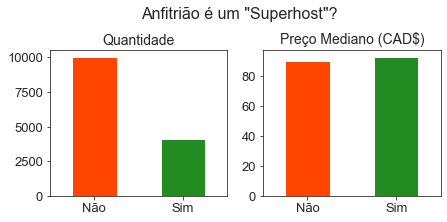

In [83]:
# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

#print(df.columns)
xlabel = ['Não', "Sim"]
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

print(df['host_is_superhost'].value_counts(normalize=True).round(2))

# Remover o "am_" para melhorar a legibilidade dos resultados
fig.suptitle('Anfitrião é um "Superhost"?', fontsize=title_fsize, y=1)
plt.subplots_adjust(top=0.8)

df.groupby('host_is_superhost').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('host_is_superhost')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title('Quantidade', fontsize=subtitle_fsize)
ax2.set_title('Preço Mediano (CAD$)', fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')    

#fig.savefig(final_figures+"is_superhost.jpeg",format='jpeg', dpi=300, bbox_inches='tight')    

### Anfitrião teve sua identidade verificada?

1.0    0.83
0.0    0.17
Name: host_identity_verified, dtype: float64
host_identity_verified
0.0    80.0
1.0    93.0
Name: price, dtype: float64


Text(0.5, 0, '')

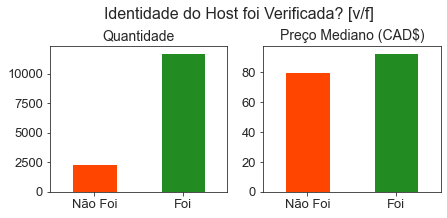

In [84]:
# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

print(df['host_identity_verified'].value_counts(normalize=True).round(2))
print(df.groupby('host_identity_verified')['price'].median())
xlabel = ['Não Foi', 'Foi']
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

# Remover o "am_" para melhorar a legibilidade dos resultados
fig.suptitle('Identidade do Host foi Verificada? [v/f]', fontsize=title_fsize)
plt.subplots_adjust(top=0.8)

df.groupby('host_identity_verified').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('host_identity_verified')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title('Quantidade', fontsize=subtitle_fsize)
ax2.set_title('Preço Mediano (CAD$)', fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')

#fig.savefig(final_figures+"is_verified.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

## Geolocalização

In [85]:
## Lista de cidades (Fonte: Wikipedia / https://en.wikipedia.org/wiki/File:North_York_Locator.png)
#display.Image("https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/North_York_Locator.png/640px-North_York_Locator.png")

In [86]:
# Visualizando, geograficamente, as propriedades por latitude e longitude

# Criando uma lista única com lat+lon
locations = list(zip(df['latitude'].tolist(), df['longitude'].tolist()))

#Gerando um mapa (folium) interativo com a quantidade de propriedades
properties_count_map = folium.Map(location=[43.70, -79.31], zoom_start=11.45)
FastMarkerCluster(data=locations).add_to(properties_count_map)

properties_count_map

In [87]:
# Gerando um mapa de calor com as quantidades de propriedades
from folium.plugins import HeatMap
properties_count_map = folium.Map(location=[43.70, -79.31], zoom_start=11.45)

HeatMap(df[['latitude','longitude']].dropna(),radius=7,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(properties_count_map)

properties_count_map


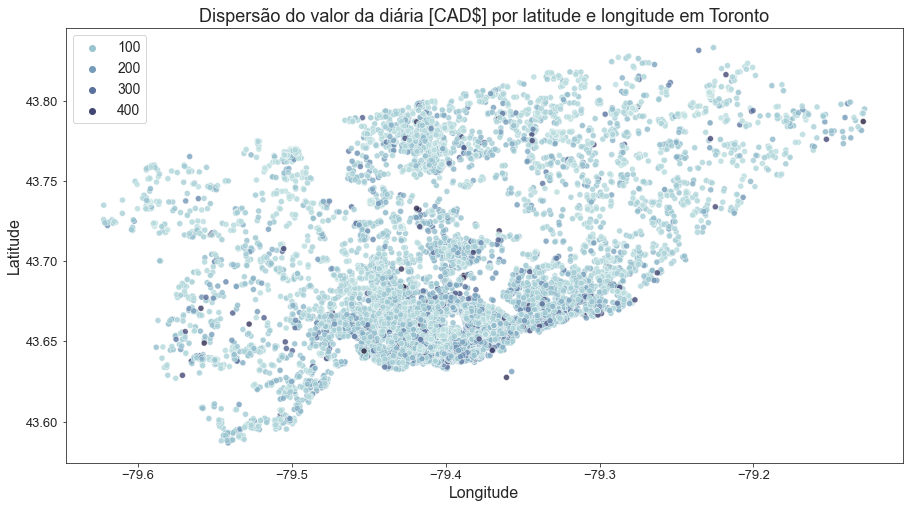

In [88]:
## Visualização de preços

# Configurações do Gráfico - Texto
title = 'Dispersão do valor da diária [CAD$] por latitude e longitude em Toronto';
xlabel = 'Longitude';
ylabel = 'Latitude';

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=16
tick_fsize=13
legend_fsize=14

plt.figure(figsize = (15,8))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
ax = sns.scatterplot(data=df, x='longitude', y='latitude', hue='price', palette=cmap, alpha=0.8)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

plt.show()

#ax.figure.savefig(final_figures+"price_per_lat_lon.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [89]:
price_list_by_n=[]

for x in range(0,len(df['geo_city'].unique())):
    sub_df=df.loc[df['geo_city'] == df["geo_city"].unique()[x]]
    price_sub_df=sub_df[['price']]
    price_list_by_n.append(price_sub_df)

#creating an empty list that we will append later with price distributions for each neighbourhood_group
#creating a for loop to get statistics for price ranges and append it to our empty list
stat_df=[]
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Estatística'}, inplace=True)
    stat_df.append(i)

#changing names of the price column to the area name for easier reading of the table    
for x in range(0,len(df['geo_city'].unique())):
    stat_df[x].rename(columns={'price':df["geo_city"].unique()[x]}, inplace=True)

#finilizing our dataframe for final view    
stat_df=[df.set_index('Estatística') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Old Toronto,York,Scarborough,East York,Etobicoke,North York
Estatística,,,,,,
min,13.0,14.0,13.0,15.0,15.00,13.00
25%,70.0,43.0,41.0,50.0,48.00,40.00
50%,100.0,65.0,60.0,74.0,75.00,64.00
75%,150.0,89.5,87.0,103.5,108.25,101.75
max,499.0,495.0,499.0,449.0,499.00,499.00


Old Toronto    0.715830
North York     0.124240
Scarborough    0.066784
Etobicoke      0.043251
York           0.032721
East York      0.017173
Name: geo_city, dtype: float64


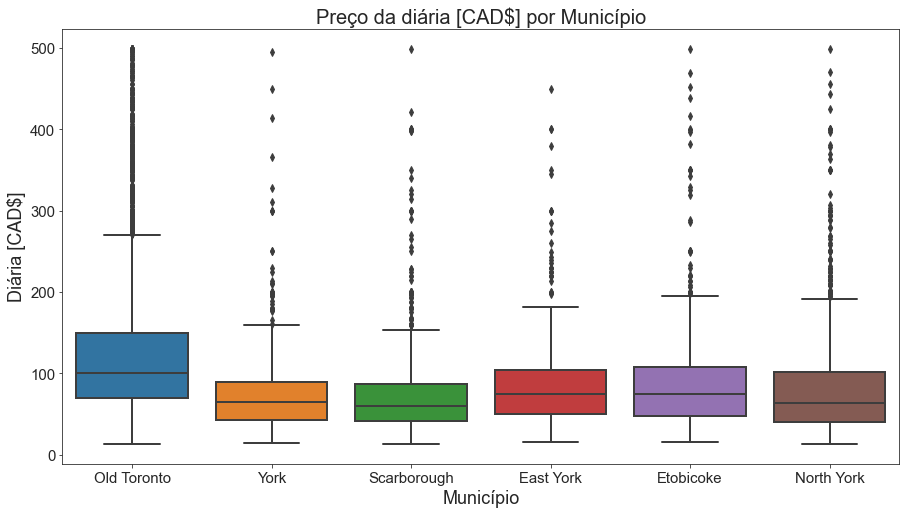

In [90]:
## Preço por cidade
# Não é nenhuma surpresa que Toronto é, de longe, uma cidade mais turísticas que as outras. Portanto, faz sentido apresentar valores levemente superiores às outras cidades
# Também é interessante aqui, vermos que 71% das propriedaeds estão em toronto, 12% em North York, e os 16% restantes nas outras 4 cidades.
# Isso explica, em partes, a estratégia de usar a separação em clusters a seguir

# Configurações do Gráfico - Texto
title='Preço da diária [CAD$] por Município'
xlabel='Município'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=20
label_fsize=18
tick_fsize=15

plt.figure(figsize = (15,8))

x = 'geo_city'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)


#ax.figure.savefig(final_figures+"price_per_city.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

print(df[x].value_counts(normalize=True))
   
plt.show()

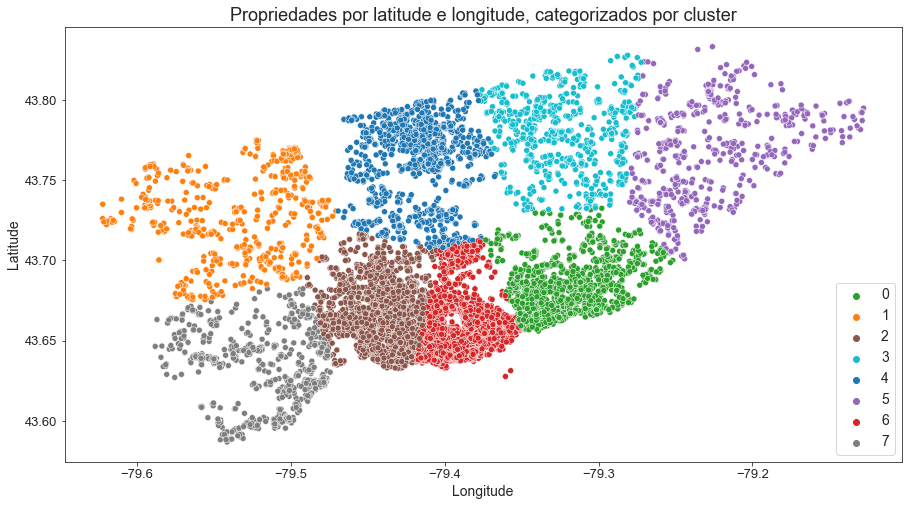

In [91]:
# Configurações do Gráfico - Texto
title='Propriedades por latitude e longitude, categorizados por cluster'
xlabel='Longitude'
ylabel='Latitude'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

plt.figure(figsize = (15,8))

color_palette=['tab:green','tab:orange','tab:brown','tab:cyan','tab:blue', 'tab:purple','tab:red','tab:gray']
ax = sns.scatterplot(data=df, x='longitude', y='latitude', hue='geo_cluster', palette=color_palette)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize, loc='lower right')

#ax.figure.savefig(final_figures+"scatter_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
# Configurações do Gráfico - Texto
title='Preço por Cluster (Kmeans)'
xlabel='ID do Cluster'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=20
label_fsize=15
tick_fsize=15

# Aqui fica claro como, ao usar clusters, conseguimos uma divisão melhor dos dados. E, novamente, podemos confirmar que o cluster 4 (Toronto), continua tendo os maiores vlaores.
plt.figure(figsize = (15,8))

x = 'geo_cluster'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2, palette=color_palette)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

#ax.figure.savefig(final_figures+"boxplot_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
   
plt.show()

## TIpo de Propriedade e Acomodação

In [ ]:
# Quantidade de propriedades (property_type) e quartos (room_type) 
# Podemos ver que a grande maioria de propriedades são apartamentos, seguido de casas. Hoteis e outros ainda são relativamente incomuns.
# A grande maioria de listagens oferecem o apartamento seguidos de quarto privados. Pouquíssimos oferecem quartos compartilhados ou de hotel.

# Configurações do Gráfico - Texto
title='Tipo mais comum de imóvel e de acomodação'
xlabel='Tipo de Imóvel (property_type)'
ylabel='Tipo de Acomodação (room_type)'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=13

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
df.groupby("property_type").size().sort_values(ascending=False).plot(kind='bar', ax=ax1, rot = 0, fontsize = 13, color=sns.color_palette("muted"))
df.groupby("room_type").size().sort_values(ascending=False).plot(kind='bar', ax=ax2, rot = 0, fontsize = 13, color=sns.color_palette("muted")[4:])

fig.suptitle(title, fontsize=title_fsize, y=1)
            
ax1.set_xlabel(xlabel, fontsize = label_fsize)
ax2.set_xlabel(ylabel, fontsize = label_fsize)

#ax.figure.savefig(final_figures+"boxplot_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
#fig.savefig(final_figures+"Tipos_prop.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
#podemos ver que o tipo de listings é proporcional. Isso é esperado. Inesperado é ver que temos pouquissimas hotel rooms em todas as cidades, apesar de que faz sentido ja q os hosts estão manipulando shit

ax = sns.catplot(x='geo_city', col='room_type', data=df, kind='count', col_wrap=2)
ax.set_xticklabels(rotation=15, fontsize=12)
ax.fig.suptitle('Número de diferentes tipo de acomodação ("room_type") por município', fontsize=18, y = 1.03)
#ax.suptitle(title, fontsize=title_fsize, y=1)

axes = ax.axes.flatten()

axes[0].set_title('Imóvel Inteiro ("Entire home/apt")', fontsize=14)
axes[1].set_title('Quarto Individual ("Private room")' , fontsize=14)
axes[2].set_title('Quarto Compartilhado ("Shared room")' , fontsize=14)
axes[3].set_title('Quarto de Hotel ("Hotel room")' , fontsize=14)
axes[0].set_ylabel('Quantidade', fontsize=14)
axes[2].set_ylabel('Quantidade', fontsize=14)

for i in range(2,len(axes)):
    axes[i].set_xlabel('Município', fontsize=14)
    
#ax.savefig(final_figures+"Tipos_room_municipio.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
# Configurações do Gráfico - Texto
title='Diária [CAD$] por Tipo de Acomodação (room_type)'
xlabel='Tipo de Acomodação'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=20
label_fsize=15
tick_fsize=15
legend_fsize=15

# Aqui fica claro que as propriedades que oferecem o apartamento inteiro ("Entire home") tem as diárias mais caras, seguidos dos quartos privados (shared room).
# Os quartos em hotéis ('Hotel room') ficam entre o apartamento inteiro e os quartos privados, embora seja bom relembrar que eles estão em quantidade muito menor.

plt.figure(figsize = (15,8))

x = 'room_type'
y = 'price'
ax = sns.violinplot(x=x, y=y, data=df, linewidth = 2, whis=10, fliersize=3)
ax.axes.set_title(title, fontsize=20)
ax.set_xlabel(xlabel, fontsize=15)
ax.set_ylabel(ylabel, fontsize=15)
ax.tick_params(labelsize=15)

#ax.figure.savefig(final_figures+"Tipos_imovel_preco.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

print(df['instant_bookable'].value_counts(normalize=True).round(2))
print(df.groupby('instant_bookable')['price'].median())
xlabel = ['Não', 'Sim']
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

# Remover o "am_" para melhorar a legibilidade dos resultados
fig.suptitle('O imóvel pode ser reservado instantâneamente? [v/f]', fontsize=title_fsize)
plt.subplots_adjust(top=0.8)

df.groupby('instant_bookable').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('instant_bookable')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title('Quantidade', fontsize=subtitle_fsize)
ax2.set_title('Preço Mediano (CAD$)', fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')

#fig.savefig(final_figures+"instant_book.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:

#Aqui ja é possível ver que Toronto tem muito mais apartamentos do que as outras cidades.

ax = sns.catplot(x='geo_city', col='property_type', data=df, kind='count', col_wrap=2)
ax.set_xticklabels(rotation=15, fontsize=12)
ax.fig.suptitle('Número de diferentes tipos de imóvel ("property_type") por cidade', fontsize=18, y = 1.03)

axes = ax.axes.flatten()

axes[0].set_title('Casa ("House")', fontsize=14)
axes[1].set_title('Apartamento ("Apartment")' , fontsize=14)
axes[2].set_title('Outros ("Other")' , fontsize=14)
axes[3].set_title('Hotel ("Hotel")' , fontsize=14)
axes[0].set_ylabel('Quantidade', fontsize=14)
axes[2].set_ylabel('Quantidade', fontsize=14)

for i in range(2, len(axes)):
    axes[i].set_xlabel('Município', fontsize=14)
    
#ax.savefig(final_figures+"Tipos_prop_municipio.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
# Configurações do Gráfico - Texto
title='Diária [CAD$] Listada por Tipo de Imóvel'
xlabel='Tipo de Imóvel ("property_type")'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

# Aqui os resultados são muito similares. Mesmo assim, é pssível ver que os apartamentos e hoteis tem valores de diarias levemente superiores.

plt.figure(figsize = (15,8))

x = 'property_type'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2, whis=10, fliersize=3)
plt.title(title, fontsize=title_fsize);
plt.xlabel(xlabel, fontsize=label_fsize);
plt.ylabel(ylabel, fontsize=label_fsize);
plt.xticks(fontsize=tick_fsize);
plt.yticks(fontsize=tick_fsize);

#ax.figure.savefig(final_figures+"Tipos_prop_preco.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

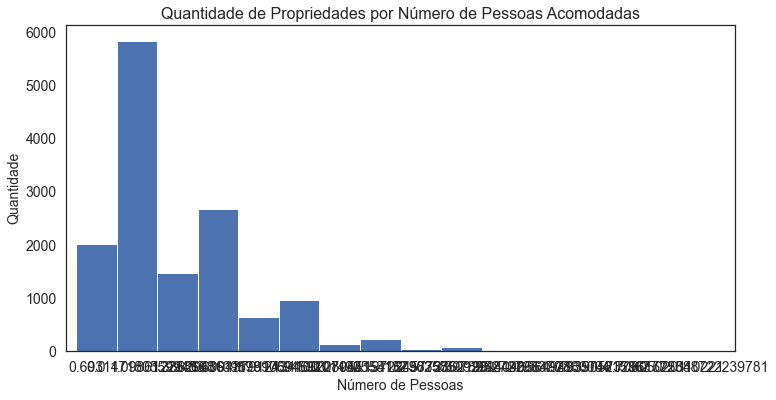

In [102]:
# Configurações do Gráfico - Texto
title='Quantidade de Propriedades por Número de Pessoas Acomodadas'
#subtitle='Agrupamento pela mediana. Erro de 1 desvio padrão'
xlabel='Número de Pessoas'
ylabel='Quantidade'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
label_fsize=14
tick_fsize=14
legend_fsize=13

feq = df['accommodates'].value_counts().sort_index()
ax=feq.plot.bar(figsize=(12,6), width=1, rot=0)
plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.show()

ax.figure.savefig(final_figures+"Prop_por_acomm.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

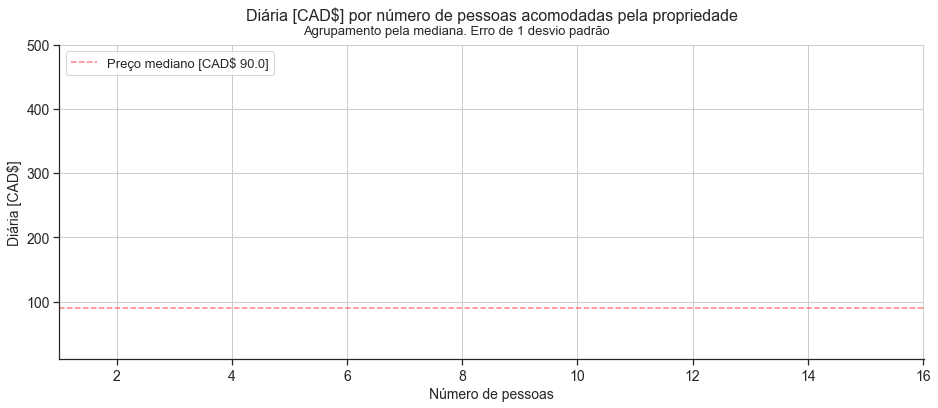

In [103]:
# Configurações do Gráfico - Texto
title='Diária [CAD$] por número de pessoas acomodadas pela propriedade'
subtitle='Agrupamento pela mediana. Erro de 1 desvio padrão'
xlabel='Número de pessoas'
ylabel='Diária [CAD$]'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=13
label_fsize=14
tick_fsize=14
legend_fsize=13

sns.set_style("ticks")
g = sns.relplot(x='accommodates', y='price', data=df, estimator='median', kind="line", ci="sd", ax=ax).set(xlim=(1,16.025), ylim=(10,500) )
plt.axhline(median_price, color='red', linestyle='--', label='Preço mediano [CAD$ '+str(median_price)+']', alpha = 0.5)
g.fig.set_size_inches(14,5)

plt.suptitle(subtitle, fontsize=subtitle_fsize, y=1.02)
plt.title(title, fontsize=title_fsize, y=1.06)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(loc='upper left', fontsize=legend_fsize)

plt.grid()

g.savefig(final_figures+"Preço_por_acomm.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
#Em outras palavras, quanto mais pessoas, mais barato
price_per_acc = df.groupby('accommodates')['price'].median().sort_values(ascending=True)                                        
print(price_per_acc)

In [ ]:
# Configurações do Gráfico - Texto
title='Crescimento da Plataforma Airbnb em Toronto, Ontario'
xlabel='Data'
ylabel='Quantidade'

# Configurações do Gráfico - Tamanho de fonte
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

#print(df.columns)
plot_variables=[]
plot_variables = list(df.columns[df.columns.str.startswith("am_") == True])
xlabel = ['Não Possui', "Possui"]
colors = ['orangered', 'forestgreen']

count=0

for col in plot_variables:
    if (abs(df.groupby(col)['price'].median()[0]-df.groupby(col)['price'].median()[1])/abs(df.groupby(col)['price'].median()[0]+df.groupby(col)['price'].median()[1]))>15/100:
        count=count+1
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
        
        # Remover o "am_" para melhorar a legibilidade dos resultados
        fig.suptitle("Ameninade " + col.replace("am_",""), fontsize=title_fsize, y=1)
        plt.subplots_adjust(top=0.8)
        
        df.groupby(col).size().plot(kind='bar', ax=ax1, color=colors)
        df.groupby(col)['price'].median().plot(kind='bar', ax=ax2, color=colors)        
        ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
        ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
        ax1.tick_params(labelsize=tick_fsize)
        ax2.tick_params(labelsize=tick_fsize)
        ax1.set_title('Quantidade', fontsize=subtitle_fsize)
        ax2.set_title('Preço Mediano (CAD$)', fontsize=subtitle_fsize)
        ax1.set_xlabel('')
        ax2.set_xlabel('')        
        
        fig.savefig(final_figures+"am"+ col.replace("am_","") +".jpeg",format='jpeg', dpi=300, bbox_inches='tight')

print("De " + str(len(plot_variables)) + " amenities, apenas " + str(count) + ' tem uma diferença considerada significativa, de 15% no preço')



# 4 - Preparação dos Dados para o Modelo

## Preparing Dummy Variables

In [ ]:
df = df.drop("host_since", axis=1)   # Transformada in host_since_days
df = df.drop("last_review", axis=1)  # Column transformed in last_review_days
df = df.drop("first_review", axis=1) # Column transformed in first_review_days
df = df.drop("host_id", axis=1)      # Useful for exploratory data analysis, but not for the model
df = df.drop("geo_city", axis=1)
df = df.drop("latitude", axis=1)
df = df.drop("longitude", axis=1)

print(df.shape)
print(df.columns)

In [93]:
df = pd.get_dummies(df, columns = ['host_response_time','host_response_rate','host_acceptance_rate','property_type','room_type'])
df = pd.get_dummies(df, columns = ['first_review_days','last_review_days','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'])
df = pd.get_dummies(df, columns = ['review_polarity']) #NLP
df = pd.get_dummies(df, columns = ['geo_cluster']) #Geo Location
print(df.shape)
print(df.columns)

(14150, 143)
Index(['host_id', 'host_since', 'host_is_superhost', 'host_identity_verified',
       'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds',
       ...
       'review_polarity_77-85%', 'review_polarity_85% +', 'geo_cluster_0',
       'geo_cluster_1', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4',
       'geo_cluster_5', 'geo_cluster_6', 'geo_cluster_7'],
      dtype='object', length=143)


## Matriz de Correlação das Features

Maior correlação é de: 1.0. Já a menor correlação é de: -0.96


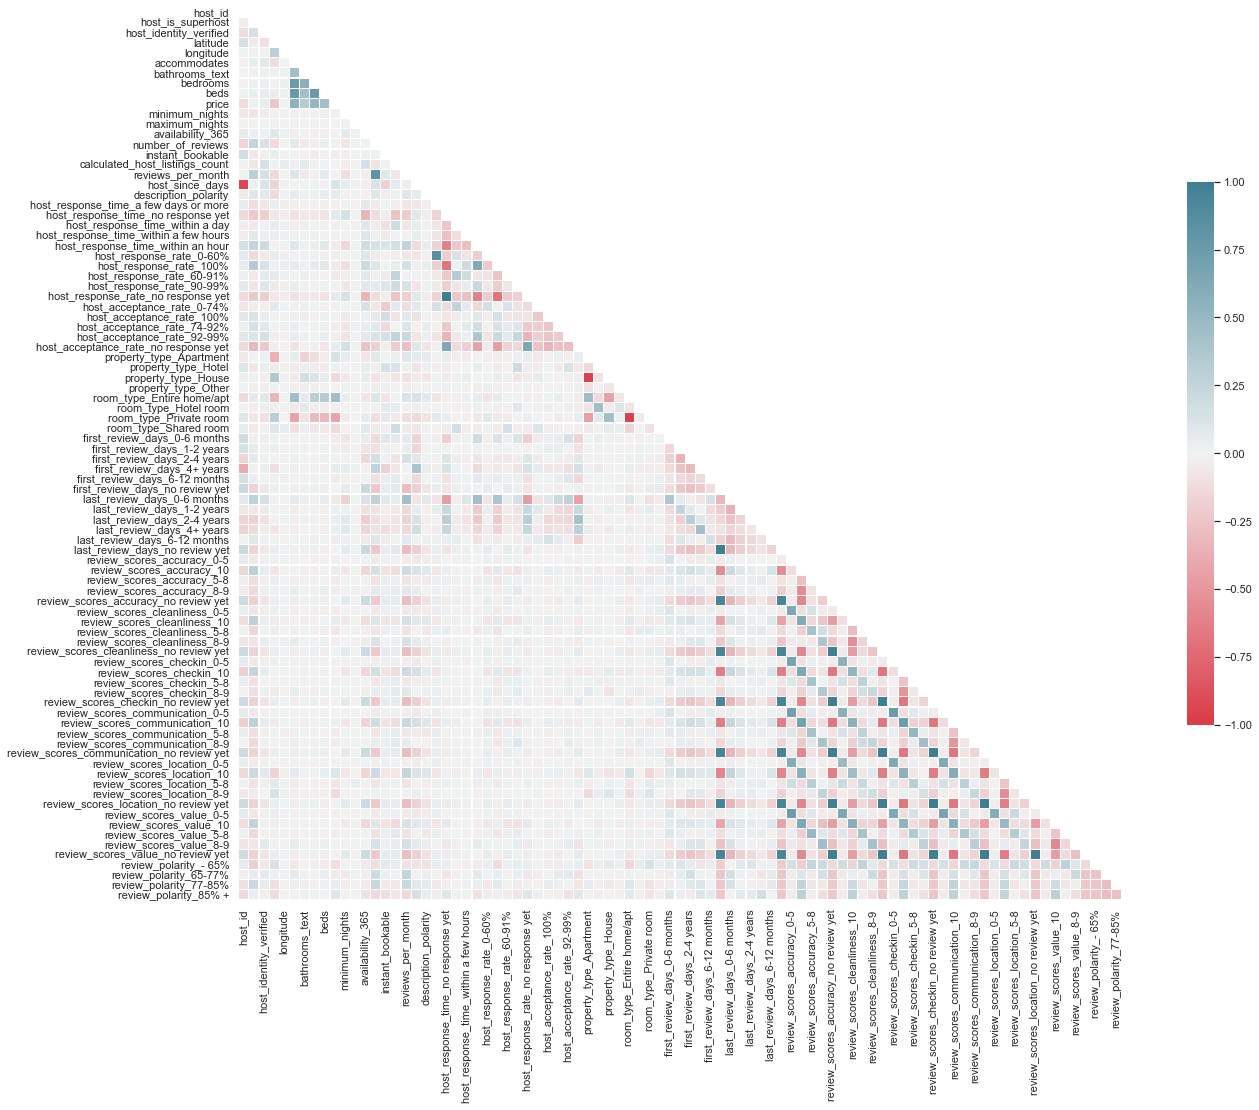

In [94]:
# Vamos remover as amenities para melhorar a legibilidade. Elas vão ser analisadas em isolamento mais a frente.
sub_df = df.drop(list(df.columns[df.columns.str.startswith('am_')]), axis=1) 
# Vamos remover, também, as áreas segmentadas em clusters.
sub_df = sub_df.drop(list(sub_df.columns[sub_df.columns.str.startswith('geo_')]), axis=1)

sns.set(style="white")
f, ax = plt.subplots(figsize=(20,20))

# Matriz de correlação SEM abs()
corr = sub_df.corr()
# Mascara (mask) precisa ter o mesmo formato de corr
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Cores (Colormap) para o heatmap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5}, vmax=1.0, vmin=-1.0);

print("Maior correlação é de: "+ str(round(corr[corr != 1.0].max().max(),2)) + ". Já a menor correlação é de: "+ str(round(corr[corr != 1.0].min().min(),2)))

#ax.figure.savefig(final_figures+"corr_matrix.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

## Matriz de Correlação das Amenidades (Amenities)

Maior correlação é de: 0.93. Já a menor correlação é de: -0.33


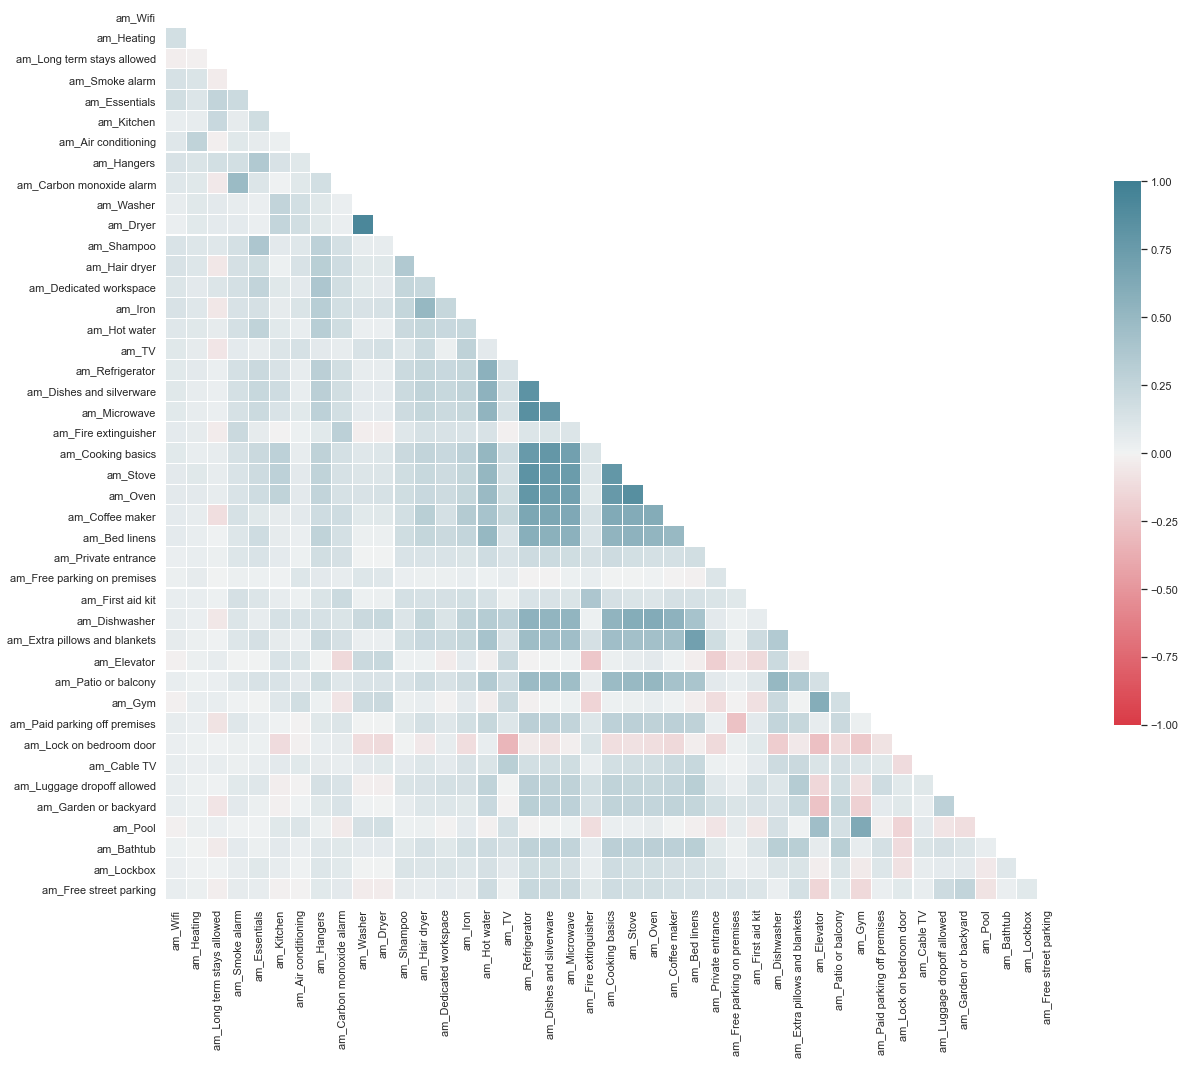

In [95]:
# Aqui, vamos analiasr as Ameninades em isolamento
amenities_columns = [col for col in df if col.startswith('am_')]
sub_df = df[amenities_columns]

sns.set(style="white")
f, ax = plt.subplots(figsize=(20,20))

corr = sub_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5}, vmax=1.0, vmin=-1.0);

print("Maior correlação é de: "+ str(round(corr[corr != 1.0].max().max(),2)) + ". Já a menor correlação é de: "+ str(round(corr[corr != 1.0].min().min(),2)))

## As correlações não passam de 0.93, como na matriz completa.
## Mesmo assim vemos alguns casos interessantes, como: Casas com Máquina de secar (Dryer) frequentemente também tem Máquina de lavar (Washer)
## Casas com pratos e talheres (Dishes and Silverware), frequentemente tem geladeiras(Refrigerator)
## Casas com Micro-ondas (Microwave), frequentemente tem geladeiras (Refrigerator)
## Casas com Stove (Fogão), frequentemente tem Oven (Forno)
#ax.figure.savefig(final_figures+"corr_matrix_2.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [96]:
# Como mais a frente vamos utilizar modelos de Random Trees e XGboost, as inter-correlações não são tão críticas.
# Mesmo assim, vamos remover somente as correlações extremas.

# Criar uma matriz de correlação absoluta
corr = df.corr().abs()

# Selecionar o triangulo superior
triangle_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Filtrar por correlações > 0.99
to_drop = [column for column in triangle_upper.columns if any(triangle_upper[column] > 0.99)]
print(to_drop)
print(len(to_drop))

# Remover (Drop) essas colunas
df.drop(to_drop, axis=1, inplace=True)

['host_response_rate_no response yet', 'last_review_days_no review yet', 'review_scores_cleanliness_no review yet', 'review_scores_checkin_no review yet', 'review_scores_communication_no review yet', 'review_scores_location_no review yet', 'review_scores_value_no review yet']
7


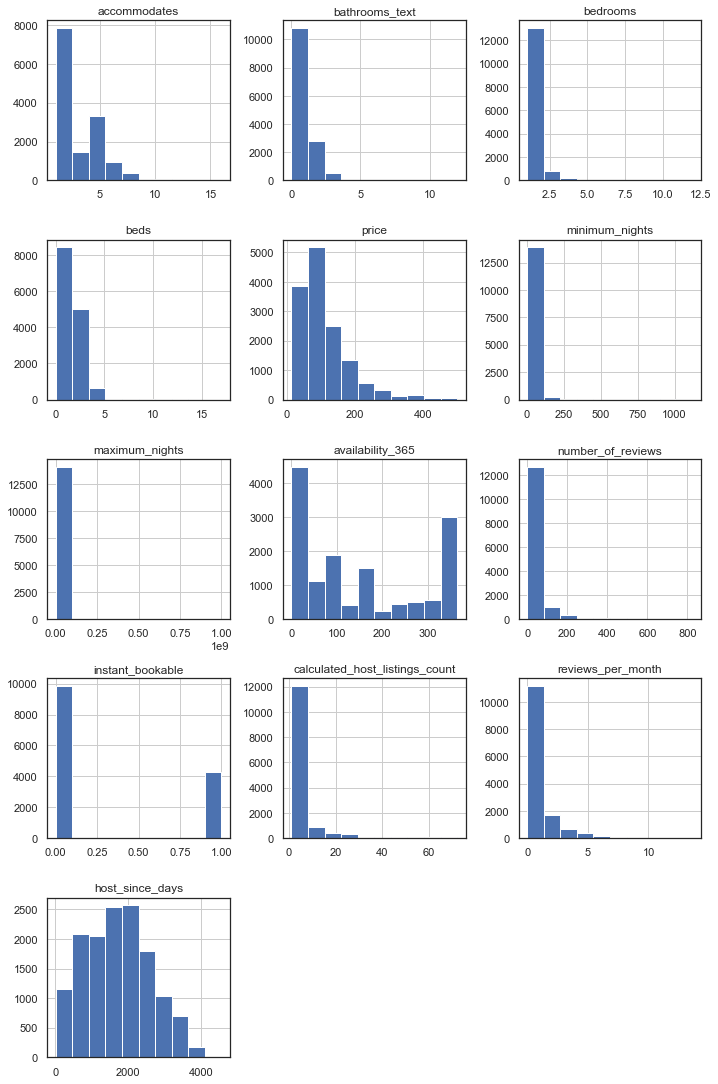

In [97]:
numerical_columns = ['accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month', 'host_since_days']


fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(numerical_columns):
    #ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(6,3, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"num_before.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [98]:
for col in numerical_columns:
    # Substituindo 0 com 0.01
    df[col] = df[col].astype('float64').replace(0.0, 0.01) 
    # Fazendo transformação logaritimica
    df[col] = np.log(df[col])

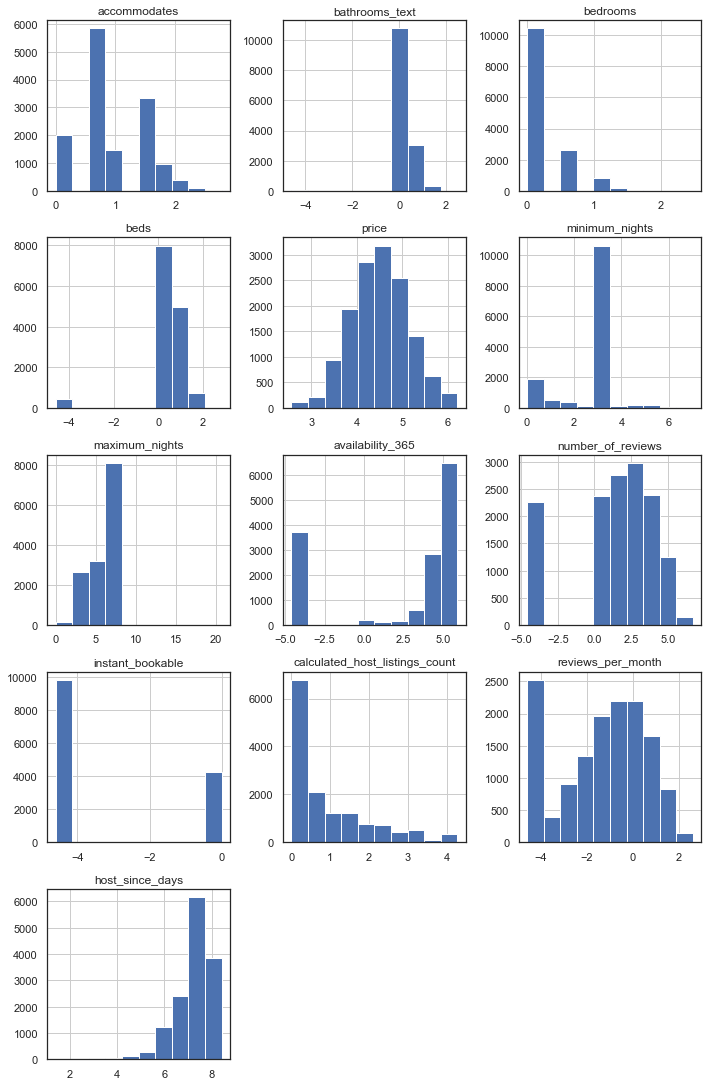

In [99]:
fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(numerical_columns):
    #ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(6,3, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"num_after.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [100]:
#Confirmando que não temos colunas nulos
df.isna().sum().sum()

4512

In [101]:
# Separando em X e y
X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

TypeError: invalid type promotion

# 5 - Modelos

In [ ]:
# Divisão em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1092867)

In [ ]:
# Performance
def AlgorithmMetrics(y_train, y_test, pred_train, pred_test):
    print("Training MSE: "  + str(round(mean_squared_error(y_train, pred_train),3)) + " | Test MSE: " + str(round(mean_squared_error(y_test, pred_test),3)))
    print("Training R²:  "  + str(round(r2_score(y_train, pred_train),3)) +           "  | Test R²:  " + str(round(r2_score(y_test, pred_test),3)))

## 1 - Random Forest

In [ ]:
# Importar o modelo que vamos utilizar
rf_reg = RandomForestRegressor(n_estimators = 250, max_features='auto')
# Fazer fit no modelo com os dados de treino
rf_reg.fit(X_train, y_train)

# Fazer predições com o modelo
rf_pred_train = rf_reg.predict(X_train)
rf_pred_test  = rf_reg.predict(X_test)

print("Random Forest Algorithm")
AlgorithmMetrics(y_train, y_test, rf_pred_train, rf_pred_test)

## 2 - XGBoost

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred_test = xgb_reg.predict(X_test)

print("XGBoost Algorithm")
AlgorithmMetrics(y_train, y_test, xgb_pred_train, xgb_pred_test)

In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
#print(ft_weights_xgb_reg.iloc(ft_weights_xgb_reg>5))
pd.set_option('display.max_rows', len(ft_weights_xgb_reg))
ft_weights_xgb_reg.head()

In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

# Plotting feature importances
plt.figure(figsize=(10,28))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.grid(zorder=0)

#plt.savefig(final_figures+"feat_import_all.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#print(ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005])

# Plotting feature importances
plt.figure(figsize=(6,8))
plt.barh(ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005].index, ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005].weight, align='center') 
plt.title("Importância dos Atributos para o modelo de XGBoost", fontsize=14)
plt.xlabel("Importância do Atributo")
plt.margins(y=0.01)
plt.grid(zorder=0)

#plt.savefig(final_figures+"feat_import_most_import.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Removendo colunas com baixa importância
all_reviews = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
reviews_to_keep1 = list(X_train.columns[X_train.columns.str.startswith("review_scores_location")])
reviews_to_keep2 = list(X_train.columns[X_train.columns.str.startswith("review_scores_cleanliness")])
reviews_to_drop = [x for x in all_reviews if x not in ((reviews_to_keep1) and (reviews_to_keep2))]

all_amenities = list(X_train.columns[X_train.columns.str.startswith("am_")])
amenities_to_keep = ['am_TV','am_Gym','am_Long term stays allowed', 'am_Dishwasher', 'am_Elevator', 'am_Lock on bedroom door']
amenities_to_drop = [x for x in all_amenities if x not in amenities_to_keep]

other_to_drop=['availability_365', 'host_is_superhost', 'number_of_reviews', 'description_polarity', 'beds', 'maximum_nights', 'instant_bookable', 'minimum_nights']


columns_to_drop = amenities_to_drop + reviews_to_drop + other_to_drop
print(len(columns_to_drop))

X_train_short = X_train.drop(columns_to_drop, axis=1)
X_test_short = X_test.drop(columns_to_drop, axis=1)

## 3 - Random Forest 2 (Com Colunas Removidas)

In [ ]:
rf2_reg = RandomForestRegressor(n_estimators = 250, max_features='auto')
rf2_reg.fit(X_train, y_train)

rf2_pred_train = rf2_reg.predict(X_train)
rf2_pred_test = rf2_reg.predict(X_test)

print("Random Forest - 2 Algorithm")
AlgorithmMetrics(y_train, y_test, rf2_pred_train, rf2_pred_test)

## 4 - XGBoost (Com Colunas Removidas)

In [ ]:
xgb2_reg = xgb.XGBRegressor()
xgb2_reg.fit(X_train, y_train)
xgb2_pred_train = xgb2_reg.predict(X_train)
xgb2_pred_test = xgb2_reg.predict(X_test)

print("XGBoost - 2 Algorithm")
AlgorithmMetrics(y_train, y_test, xgb2_pred_train, xgb2_pred_test)x

In [ ]:
print("Tempo de execução: "+ str(round((time.time() - start_time)/60,1)) + " minutos. Última execução em: " + str(datetime.now(tz=None)))